In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [3]:
df_censo = pd.read_csv('../database/Cantidad-de-Personas-por-Sexo-y-Edad.csv', sep=";")
df_farmacias = pd.read_csv("../database/2.-Farmacias-Chile-07.2023.csv", sep=";", encoding="utf-8")
df_hospitales = pd.read_excel("../database/Establecimientos_ChileDEIS_MINSAL 03-11-2023.xlsx", sheet_name="Establecimientos Vigentes")

def modificar_nombre_columna(nombre: str):
    nombre = nombre.strip()  
    nombre = nombre.lower() 
    nombre = nombre.replace(" ", "_")
    nombre = nombre.replace("\xa0", "_")
    return nombre

nuevos_nombres = {columna: modificar_nombre_columna(columna) for columna in df_censo.columns}
df_censo.rename(columns=nuevos_nombres, inplace=True)
df_censo.columns

df_censo["código_región"] = pd.to_numeric(df_censo["código_región"], errors="coerce")
df_censo["código_provincia"] = pd.to_numeric(df_censo["código_provincia"], errors="coerce")
df_censo["código_comuna"] = pd.to_numeric(df_censo["código_comuna"], errors="coerce")
df_censo["edad"] = df_censo["edad"].astype("category")
df_censo["hombres"] = df_censo["hombres"].str.replace(".", "").astype("int")
df_censo["mujeres"] = df_censo["mujeres"].str.replace(".", "").astype("int")
df_censo["total"] = df_censo["total"].str.replace(".", "").astype("int")

df_hospitales.columns = df_hospitales.loc[0,:]
df_hospitales.drop(0, inplace=True)
df_hospitales.drop(columns=["Código Antiguo ", "Código  Madre Antiguo", "Código Madre Nuevo", "Código  Madre Antiguo", "Fecha de Incorporación a la base o cambios", "Teléfono", "Fecha Inicio Funcionamiento", "Vía", "Certificación ", "Número", "Dirección", "Clasificcion Tipo de SAPU", "Dependencia Administrativa"], inplace=True)

En las categorías de Tipo de Urgencia (en la que se trabajará), se identifica una duplicación de algunos por uso de minúsculas/mayúsculas de forma diferenciada. Por lo que se hace un replace.

In [ ]:
df_hospitales.loc[:,"Tipo de Urgencia "] = df_hospitales.loc[:,"Tipo de Urgencia "].str.replace("ambulatoria", "Ambulatoria")

In [4]:
df_hospitales.replace(["No Aplica", "Pendiente", "Completar", "No Aplica", "Por confirmar", "no Aplica", "Pendiente", "no aplica", "No Aplica"], np.NaN, inplace=True)

df_hospitales["Código Vigente"] = df_hospitales["Código Vigente"].astype("int")

df_hospitales["Código Región"] = df_hospitales["Código Región"].astype("int")

df_hospitales["Código Dependencia Jerárquica (SEREMI / Servicio de Salud)"] = df_hospitales["Código Dependencia Jerárquica (SEREMI / Servicio de Salud)"].astype("float")

df_hospitales["Pertenencia al SNSS"] = df_hospitales["Pertenencia al SNSS"].map(lambda x: x == 'Perteneciente' or x == True)
df_hospitales["Pertenencia al SNSS"] = df_hospitales["Pertenencia al SNSS"].astype("bool")

df_hospitales["Nivel de Atención"] = df_hospitales["Nivel de Atención"].astype("category")

df_hospitales["Tiene Servicio de Urgencia"] = df_hospitales["Tiene Servicio de Urgencia"].map(lambda x: x == 'SI' or x == True)
df_hospitales["Tiene Servicio de Urgencia"] = df_hospitales["Tiene Servicio de Urgencia"].astype("bool")
df_hospitales["Tipo de Urgencia "] = df_hospitales["Tipo de Urgencia "].astype("category")
df_hospitales["Tipo de Prestador Sistema de Salud"] = df_hospitales["Tipo de Prestador Sistema de Salud"].astype("category")

df_hospitales["Nivel de Complejidad"] = df_hospitales["Nivel de Complejidad"].astype("category")
df_hospitales["Tipo de Atención "] = df_hospitales["Tipo de Atención "].astype("category")
df_hospitales = df_hospitales[df_hospitales['Estado de Funcionamiento'].str.contains("Vigente", case=False, na=False)]
df_hospitales.drop(columns="Estado de Funcionamiento", inplace=True)

In [7]:

nuevos_nombres = {columna: modificar_nombre_columna(columna) for columna in df_hospitales.columns}
df_hospitales.rename(columns=nuevos_nombres, inplace=True)
df_hospitales.rename(columns={"latitud______[grados_decimales]": "latitud", "longitud_[grados_decimales]":"longitud"}, inplace=True)
df_hospitales["código_región"] = df_hospitales["código_región"].astype("int")
df_hospitales["código_comuna"] = df_hospitales["código_comuna"].astype("int")
df_hospitales["nombre_comuna"] = df_hospitales["nombre_comuna"].str.upper()
df_hospitales["tipo_establecimiento_(unidad)"] = df_hospitales["tipo_establecimiento_(unidad)"].str.strip()

df_hospitales.loc[df_hospitales["nombre_región"] == "Región De los Ríos", "nombre_región"] = "Región De Los Ríos"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "CHILLÁN ", "nombre_comuna"] = "CHILLÁN"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "LICANTEN", "nombre_comuna"] = "LICANTÉN"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "VICHUQUEN", "nombre_comuna"] = "VICHUQUÉN"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "CALERA","nombre_comuna"] = "LA CALERA"
df_hospitales.loc[df_hospitales["nombre_comuna"] == "LAS CONDES", "código_comuna"] = 13114
df_hospitales.loc[df_hospitales["nombre_comuna"] == "LA FLORIDA", "código_comuna"] = 13110



In [8]:
comunas_ñuble = {16109: 'YUNGAY',
 16105: 'PEMUCO',
 16104: 'EL CARMEN',
 16107: 'QUILLÓN',
 16108: 'SAN IGNACIO',
 16106: 'PINTO',
 16102: 'BULNES',
 16302: 'COIHUECO',
 16103: 'CHILLÁN VIEJO',
 16206: 'RÁNQUIL',
 16304: 'SAN FABIÁN',
 16101: 'CHILLÁN',
 16205: 'PORTEZUELO',
 16203: 'COELEMU',
 16305: 'SAN NICOLÁS',
 16301: 'SAN CARLOS',
 16207: 'TREGUACO',
 16204: 'NINHUE',
 16303: 'ÑIQUÉN',
 16201: 'QUIRIHUE',
 16202: 'COBQUECURA'}
comunas_ñuble = {v: k for k, v in comunas_ñuble.items()}


provincias_ñuble = {
    161: "DIGUILLÍN",
    162: "ITATA",
    163: "PUNILLA"
}


In [9]:
d = df_censo[df_censo["nombre_provincia"].str.contains("ÑUBLE")]
d["nombre_comuna"] = d["nombre_comuna"].str.replace(" *", "")
d
d["código_comuna"] = d["nombre_comuna"].map(comunas_ñuble).astype("string")
d["nombre_región"] = "ÑUBLE"
d["código_región"] = 16
d["código_provincia"] = d["código_comuna"].str.slice(0,3)
d["código_provincia"] = d["código_provincia"].astype("int")
d["nombre_provincia"] = d["código_provincia"].map(provincias_ñuble)

/tmp/ipykernel_2271/4203659101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["nombre_comuna"] = d["nombre_comuna"].str.replace(" *", "")
/tmp/ipykernel_2271/4203659101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["código_comuna"] = d["nombre_comuna"].map(comunas_ñuble).astype("string")
/tmp/ipykernel_2271/4203659101.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [10]:
df_censo.drop(df_censo[df_censo["nombre_provincia"].str.contains("ÑUBLE")].index, inplace=True)
df_censo = pd.concat([df_censo, d], ignore_index=True)
df_censo.sort_values(by="orden", inplace=True)
df_censo["código_comuna"] = df_censo["código_comuna"].astype("float")

codigo_comuna_a_provincia = dict(zip(df_censo['código_comuna'], df_censo['código_provincia']))
codigo_comuna_a_provincia = {int(comuna): int(provincia) for comuna, provincia in codigo_comuna_a_provincia.items() if not pd.isna(comuna)}
df_hospitales.loc[:, "código_provincia"] = df_hospitales["código_comuna"].map(codigo_comuna_a_provincia)
df_hospitales["código_provincia"] = df_hospitales["código_provincia"].astype("int")

codigo_comuna_a_region = dict(zip(df_censo['código_comuna'], df_censo['nombre_provincia']))
codigo_comuna_a_region = {int(comuna): str(provincia) for comuna, provincia in codigo_comuna_a_region.items() if not pd.isna(comuna)}
df_hospitales.loc[:, "nombre_provincia"] = df_hospitales["código_comuna"].map(codigo_comuna_a_region)
df_hospitales["código_provincia"] = df_hospitales["código_provincia"].astype("int")

In [11]:
nombre_comuna_a_codigo_comuna = {'ARICA': 15101, 'CAMARONES': 15102, 'PUTRE': 15201, 'GENERAL LAGOS': 15202, 'IQUIQUE': 1101, 'ALTO HOSPICIO': 1107, 'POZO ALMONTE': 1401, 'CAMIÑA': 1402, 'CAMINA': 1402, 'COLCHANE': 1403, 'HUARA': 1404, 'PICA': 1405, 'ANTOFAGASTA': 2101, 'MEJILLONES': 2102, 'SIERRA GORDA': 2103, 'TALTAL': 2104, 'CALAMA': 2201, 'OLLAGÜE': 2202, 'OLLAGUE': 2202, 'SAN PEDRO DE ATACAMA': 2203, 'TOCOPILLA': 2301, 'MARÍA ELENA': 2302, 'MARIA ELENA': 2302, 'COPIAPÓ': 3101, 'COPIAPO': 3101, 'CALDERA': 3102, 'TIERRA AMARILLA': 3103, 'CHAÑARAL': 3201, 'CHANARAL': 3201, 'DIEGO DE ALMAGRO': 3202, 'VALLENAR': 3301, 'ALTO DEL CARMEN': 3302, 'FREIRINA': 3303, 'HUASCO': 3304, 'LA SERENA': 4101, 'COQUIMBO': 4102, 'ANDACOLLO': 4103, 'LA HIGUERA': 4104, 'PAIGUANO': 4105, 'VICUÑA': 4106, 'VICUNA': 4106, 'ILLAPEL': 4201, 'CANELA': 4202, 'LOS VILOS': 4203, 'SALAMANCA': 4204, 'OVALLE': 4301, 'COMBARBALÁ': 4302, 'COMBARBALA': 4302, 'MONTE PATRIA': 4303, 'PUNITAQUI': 4304, 'RÍO HURTADO': 4305, 'RIO HURTADO': 4305, 'VALPARAÍSO': 5101, 'VALPARAISO': 5101, 'CASABLANCA': 5102, 'CONCÓN': 5103, 'CONCON': 5103, 'JUAN FERNÁNDEZ': 5104, 'JUAN FERNANDEZ': 5104, 'PUCHUNCAVÍ': 5105, 'PUCHUNCAVI': 5105, 'QUINTERO': 5107, 'VIÑA DEL MAR': 5109, 'VINA DEL MAR': 5109, 'ISLA DE PASCUA': 5201, 'LOS ANDES': 5301, 'CALLE LARGA': 5302, 'RINCONADA': 5303, 'SAN ESTEBAN': 5304, 'LA LIGUA': 5401, 'CABILDO': 5402, 'PAPUDO': 5403, 'PETORCA': 5404, 'ZAPALLAR': 5405, 'QUILLOTA': 5501, 'CALERA': 5502, 'LA CALERA': 5502, 'HIJUELAS': 5503, 'LA CRUZ': 5504, 'NOGALES': 5506, 'SAN ANTONIO': 5601, 'ALGARROBO': 5602, 'CARTAGENA': 5603, 'EL QUISCO': 5604, 'EL TABO': 5605, 'SANTO DOMINGO': 5606, 'SAN FELIPE': 5701, 'CATEMU': 5702, 'LLAILLAY': 5703, 'PANQUEHUE': 5704, 'PUTAENDO': 5705, 'SANTA MARÍA': 5706, 'SANTA MARIA': 5706, 'QUILPUÉ': 5801, 'QUILPUE': 5801, 'LIMACHE': 5802, 'OLMUÉ': 5803, 'OLMUE': 5803, 'VILLA ALEMANA': 5804, 'SANTIAGO': 13101, 'CERRILLOS': 13102, 'CERRO NAVIA': 13103, 'CONCHALÍ': 13104, 'CONCHALI': 13104, 'EL BOSQUE': 13105, 'ESTACIÓN CENTRAL': 13106, 'ESTACION CENTRAL': 13106, 'HUECHURABA': 13107, 'INDEPENDENCIA': 13108, 'LA CISTERNA': 13109, 'LA FLORIDA': 13110, 'LA GRANJA': 13111, 'LA PINTANA': 13112, 'LA REINA': 13113, 'LAS CONDES': 13114, 'LO BARNECHEA': 13115, 'LO ESPEJO': 13116, 'LO PRADO': 13117, 'MACUL': 13118, 'MAIPÚ': 13119, 'MAIPU': 13119, 'ÑUÑOA': 13120, 'NUNOA': 13120, 'PEDRO AGUIRRE CERDA': 13121, 'PEÑALOLÉN': 13122, 'PENALOLEN': 13122, 'PROVIDENCIA': 13123, 'PUDAHUEL': 13124, 'QUILICURA': 13125, 'QUINTA NORMAL': 13126, 'RECOLETA': 13127, 'RENCA': 13128, 'SAN JOAQUÍN': 13129, 'SAN JOAQUIN': 13129, 'SAN MIGUEL': 13130, 'SAN RAMÓN': 13131, 'SAN RAMON': 13131, 'VITACURA': 13132, 'PUENTE ALTO': 13201, 'PIRQUE': 13202, 'SAN JOSÉ DE MAIPO': 13203, 'SAN JOSE DE MAIPO': 13203, 'COLINA': 13301, 'LAMPA': 13302, 'TILTIL': 13303, 'TIL-TIL': 13303, 'SAN BERNARDO': 13401, 'BUIN': 13402, 'CALERA DE TANGO': 13403, 'PAINE': 13404, 'MELIPILLA': 13501, 'ALHUÉ': 13502, 'ALHUE': 13502, 'CURACAVÍ': 13503, 'CURACAVI': 13503, 'MARÍA PINTO': 13504, 'MARIA PINTO': 13504, 'SAN PEDRO': 13505, 'TALAGANTE': 13601, 'EL MONTE': 13602, 'ISLA DE MAIPO': 13603, 'PADRE HURTADO': 13604, 'PEÑAFLOR': 13605, 'PENAFLOR': 13605, 'RANCAGUA': 6101, 'CODEGUA': 6102, 'COINCO': 6103, 'COLTAUCO': 6104, 'DOÑIHUE': 6105, 'DONIHUE': 6105, 'GRANEROS': 6106, 'LAS CABRAS': 6107, 'MACHALÍ': 6108, 'MACHALI': 6108, 'MALLOA': 6109, 'MOSTAZAL': 6110, 'OLIVAR': 6111, 'PEUMO': 6112, 'PICHIDEGUA': 6113, 'QUINTA DE TILCOCO': 6114, 'RENGO': 6115, 'REQUÍNOA': 6116, 'REQUINOA': 6116, 'SAN VICENTE': 6117, 'PICHILEMU': 6201, 'LA ESTRELLA': 6202, 'LITUECHE': 6203, 'MARCHIHUE': 6204, 'NAVIDAD': 6205, 'PAREDONES': 6206, 'SAN FERNANDO': 6301, 'CHÉPICA': 6302, 'CHEPICA': 6302, 'CHIMBARONGO': 6303, 'LOLOL': 6304, 'NANCAGUA': 6305, 'PALMILLA': 6306, 'PERALILLO': 6307, 'PLACILLA': 6308, 'PUMANQUE': 6309, 'SANTA CRUZ': 6310, 'TALCA': 7101, 'CONSTITUCIÓN': 7102, 'CONSTITUCION': 7102, 'CUREPTO': 7103, 'EMPEDRADO': 7104, 'MAULE': 7105, 'PELARCO': 7106, 'PENCAHUE': 7107, 'RÍO CLARO': 7108, 'RIO CLARO': 7108, 'SAN CLEMENTE': 7109, 'SAN RAFAEL': 7110, 'CAUQUENES': 7201, 'CHANCO': 7202, 'PELLUHUE': 7203, 'CURICÓ': 7301, 'CURICO': 7301, 'HUALAÑÉ': 7302, 'HUALANE': 7302, 'LICANTÉN': 7303, 'LICANTEN': 7303, 'MOLINA': 7304, 'RAUCO': 7305, 'ROMERAL': 7306, 'SAGRADA FAMILIA': 7307, 'TENO': 7308, 'VICHUQUÉN': 7309, 'VICHUQUEN': 7309, 'LINARES': 7401, 'COLBÚN': 7402, 'COLBUN': 7402, 'LONGAVÍ': 7403, 'LONGAVI': 7403, 'PARRAL': 7404, 'RETIRO': 7405, 'SAN JAVIER': 7406, 'VILLA ALEGRE': 7407, 'YERBAS BUENAS': 7408, 'CONCEPCIÓN': 8101, 'CONCEPCION': 8101, 'CORONEL': 8102, 'CHIGUAYANTE': 8103, 'FLORIDA': 8104, 'HUALQUI': 8105, 'LOTA': 8106, 'PENCO': 8107, 'SAN PEDRO DE LA PAZ': 8108, 'SANTA JUANA': 8109, 'TALCAHUANO': 8110, 'TOMÉ': 8111, 'TOME': 8111, 'HUALPÉN': 8112, 'HUALPEN': 8112, 'LEBU': 8201, 'ARAUCO': 8202, 'CAÑETE': 8203, 'CANETE': 8203, 'CONTULMO': 8204, 'CURANILAHUE': 8205, 'LOS ÁLAMOS': 8206, 'LOS ALAMOS': 8206, 'TIRÚA': 8207, 'TIRUA': 8207, 'LOS ÁNGELES': 8301, 'LOS ANGELES': 8301, 'ANTUCO': 8302, 'CABRERO': 8303, 'LAJA': 8304, 'MULCHÉN': 8305, 'MULCHEN': 8305, 'NACIMIENTO': 8306, 'NEGRETE': 8307, 'QUILACO': 8308, 'QUILLECO': 8309, 'SAN ROSENDO': 8310, 'SANTA BÁRBARA': 8311, 'SANTA BARBARA': 8311, 'TUCAPEL': 8312, 'YUMBEL': 8313, 'ALTO BIOBÍO': 8314, 'ALTO BIOBIO': 8314, 'CHILLÁN': 16101, 'CHILLAN': 16101, 'BULNES': 16102, 'COBQUECURA': 16202, 'COELEMU': 16203, 'COIHUECO': 16302, 'CHILLÁN VIEJO': 16103, 'CHILLAN VIEJO': 16103, 'EL CARMEN': 16104, 'NINHUE': 16204, 'ÑIQUÉN': 16303, 'NIQUEN': 16303, 'PEMUCO': 16105, 'PINTO': 16106, 'PORTEZUELO': 16205, 'QUILLÓN': 16107, 'QUILLON': 16107, 'QUIRIHUE': 16201, 'RÁNQUIL': 16206, 'RANQUIL': 16206, 'SAN CARLOS': 16301, 'SAN FABIÁN': 16304, 'SAN FABIAN': 16304, 'SAN IGNACIO': 16108, 'SAN NICOLÁS': 16305, 'SAN NICOLAS': 16305, 'TREGUACO': 16207, 'YUNGAY': 16109, 'TEMUCO': 9101, 'CARAHUE': 9102, 'CUNCO': 9103, 'CURARREHUE': 9104, 'FREIRE': 9105, 'GALVARINO': 9106, 'GORBEA': 9107, 'LAUTARO': 9108, 'LONCOCHE': 9109, 'MELIPEUCO': 9110, 'NUEVA IMPERIAL': 9111, 'PADRE LAS CASAS': 9112, 'PERQUENCO': 9113, 'PITRUFQUÉN': 9114, 'PITRUFQUEN': 9114, 'PUCÓN': 9115, 'PUCON': 9115, 'SAAVEDRA': 9116, 'TEODORO SCHMIDT': 9117, 'TOLTÉN': 9118, 'TOLTEN': 9118, 'VILCÚN': 9119, 'VILCUN': 9119, 'VILLARRICA': 9120, 'CHOLCHOL': 9121, 'ANGOL': 9201, 'COLLIPULLI': 9202, 'CURACAUTÍN': 9203, 'CURACAUTIN': 9203, 'ERCILLA': 9204, 'LONQUIMAY': 9205, 'LOS SAUCES': 9206, 'LUMACO': 9207, 'PURÉN': 9208, 'PUREN': 9208, 'RENAICO': 9209, 'TRAIGUÉN': 9210, 'TRAIGUEN': 9210, 'VICTORIA': 9211, 'VALDIVIA': 14101, 'CORRAL': 14102, 'LANCO': 14103, 'LOS LAGOS': 14104, 'MÁFIL': 14105, 'MAFIL': 14105, 'MARIQUINA': 14106, 'PAILLACO': 14107, 'PANGUIPULLI': 14108, 'LA UNIÓN': 14201, 'LA UNION': 14201, 'FUTRONO': 14202, 'LAGO RANCO': 14203, 'RÍO BUENO': 14204, 'RIO BUENO': 14204, 'PUERTO MONTT': 10101, 'CALBUCO': 10102, 'COCHAMÓ': 10103, 'COCHAMO': 10103, 'FRESIA': 10104, 'FRUTILLAR': 10105, 'LOS MUERMOS': 10106, 'LLANQUIHUE': 10107, 'MAULLÍN': 10108, 'MAULLIN': 10108, 'PUERTO VARAS': 10109, 'CASTRO': 10201, 'ANCUD': 10202, 'CHONCHI': 10203, 'CURACO DE VÉLEZ': 10204, 'CURACO DE VELEZ': 10204, 'DALCAHUE': 10205, 'PUQUELDÓN': 10206, 'PUQUELDON': 10206, 'QUEILÉN': 10207, 'QUEILEN': 10207, 'QUELLÓN': 10208, 'QUELLON': 10208, 'QUEMCHI': 10209, 'QUINCHAO': 10210, 'OSORNO': 10301, 'PUERTO OCTAY': 10302, 'PURRANQUE': 10303, 'PUYEHUE': 10304, 'RÍO NEGRO': 10305, 'RIO NEGRO': 10305, 'SAN JUAN DE LA COSTA': 10306, 'SAN PABLO': 10307, 'CHAITÉN': 10401, 'CHAITEN': 10401, 'FUTALEUFÚ': 10402, 'FUTALEUFU': 10402, 'HUALAIHUÉ': 10403, 'HUALAIHUE': 10403, 'PALENA': 10404, 'COYHAIQUE': 11101, 'LAGO VERDE': 11102, 'AYSÉN': 11201, 'AYSEN': 11201, 'CISNES': 11202, 'GUAITECAS': 11203, 'COCHRANE': 11301, "O'HIGGINS": 11302, 'TORTEL': 11303, 'CHILE CHICO': 11401, 'RÍO IBÁÑEZ': 11402, 'RIO IBANEZ': 11402, 'PUNTA ARENAS': 12101, 'LAGUNA BLANCA': 12102, 'RÍO VERDE': 12103, 'RIO VERDE': 12103, 'SAN GREGORIO': 12104, 'CABO DE HORNOS': 12201, 'ANTÁRTICA': 12202, 'ANTARTICA': 12202, 'PORVENIR': 12301, 'PRIMAVERA': 12302, 'TIMAUKEL': 12303, 'NATALES': 12401, 'TORRES DEL PAINE': 12402, 'SAN FRANCISCO DE MOSTAZAL': 6110, 'ALTO BIO BIO': 8314, 'PUERTO NATALES': 12401, 'LLAY LLAY': 5703, 'MARCHIGUE': 6204, 'CHOL CHOL': 9121, 'PAIHUANO': 4105}

In [12]:
df_farmacias.loc[:,"código_comuna"] = df_farmacias.loc[:,"Comuna"].str.replace("Ñ", "N").map(nombre_comuna_a_codigo_comuna)
df_farmacias.loc[:,"código_provincia"] = df_farmacias.loc[:,"código_comuna"].map(codigo_comuna_a_provincia)
df_farmacias.loc[:,"código_región"] = df_farmacias.loc[:,"código_comuna"].map(codigo_comuna_a_region)

df_farmacias.dropna(subset="Comuna", inplace=True)
df_farmacias["código_comuna"] = df_farmacias["código_comuna"].astype("int")

nuevos_nombres = {columna: modificar_nombre_columna(columna) for columna in df_farmacias.columns}
df_farmacias.rename(columns=nuevos_nombres, inplace=True)

df_farmacias["latitud"] = pd.to_numeric(df_farmacias['latitud'], errors='coerce')
df_farmacias["longitud"] = pd.to_numeric(df_farmacias['longitud'], errors='coerce')

### Pregunta 01: ¿En que region y comuna se encuentra la mayor y la menor concentracion de servicios ḿedicos?


In [13]:
df_hospitales_1 = df_hospitales[(~df_hospitales["tipo_de_prestador_sistema_de_salud"].isin(['Fuerzas Armadas y de Orden', 'Institución Medicina Legal']))]
df_hospitales_1 = df_hospitales_1[(~df_hospitales_1["ámbito_de_funcionamiento"].isin(['Hospital',
 'Posta de Salud Rural (PSR)',
 'Centro Comunitario de Salud Familiar (CECOSF)',
 'Servicio de Atención Primaria de Urgencia de Alta Resolutividad (SAR)',
 'Centro de Salud Familiar (CESFAM)',
 'Centro de Salud Privado',
 'Unidad de Salud Funcionarios',
 'Dirección Servicio de Salud',
 'Servicio de Atención Primaria de Urgencia (SAPU)',
 'Clínica',
 'Consultorio General Urbano  (CGU)',
 'Unidad de Procedimientos Móvil',
 'Servicio de Urgencia Rural (SUR)',
 'Centro de Diagnóstico y Terapeútico (CDT)',
 'Hospital de Día Infanto Adolescente',
 'Consultorio General Rural (CGR)',
 'Centro de Referencia de Salud (CRS)',
 'Centro Corporación para la Nutrición Infantil (CONIN)',
 'Hospital de Dia Adulto',
 'Puesto de Atención Médica Especializado (PAME) Incorporado por Crisis Sanitaria',
 'Centro de Especialidad',
 'Centros Exclusivos de Atención Respiratoria (CEAR)',
 'Especialidades  Primarias',
 'Centro de Regulación Médica de las Urgencias (SAMU)',
 'Centros de Diagnóstico y Tratamiento Privados',
 'Policlínico Funcionarios (Minería)',
 'Centro de Especialidades Primarias',
 'Centro Radiológico',
 'Centro de Salud']))]


In [32]:
df_poblacion = df_censo[df_censo["nombre_comuna"] != "PAÍS"]
df_poblacion_por_comuna = df_poblacion[df_poblacion["edad"] == "Total Comunal"]
df_poblacion_por_provincia = pd.pivot_table(df_poblacion_por_comuna, index="código_provincia", values=["hombres", "mujeres", "total"], aggfunc=np.sum)
df_poblacion_por_region = pd.pivot_table(df_poblacion_por_comuna, index="código_región", values=["hombres", "mujeres", "total"], aggfunc=np.sum)


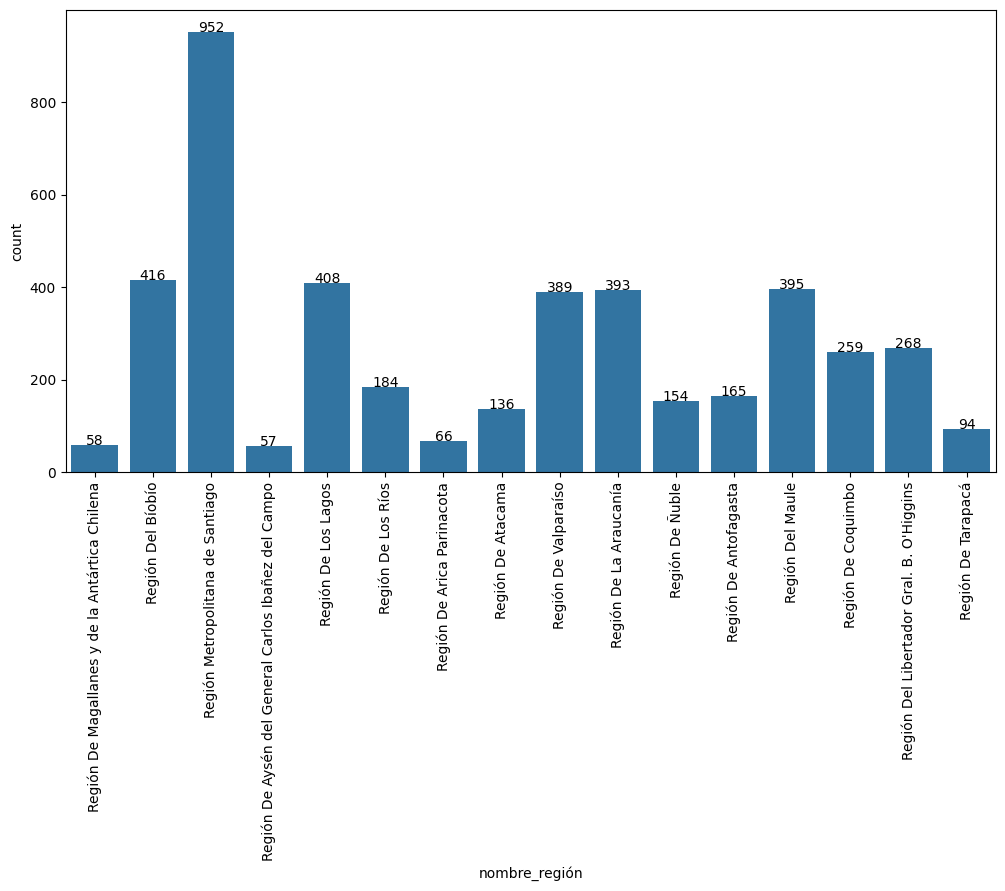

In [15]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="nombre_región", data=df_hospitales_1)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=90)
plt.show()

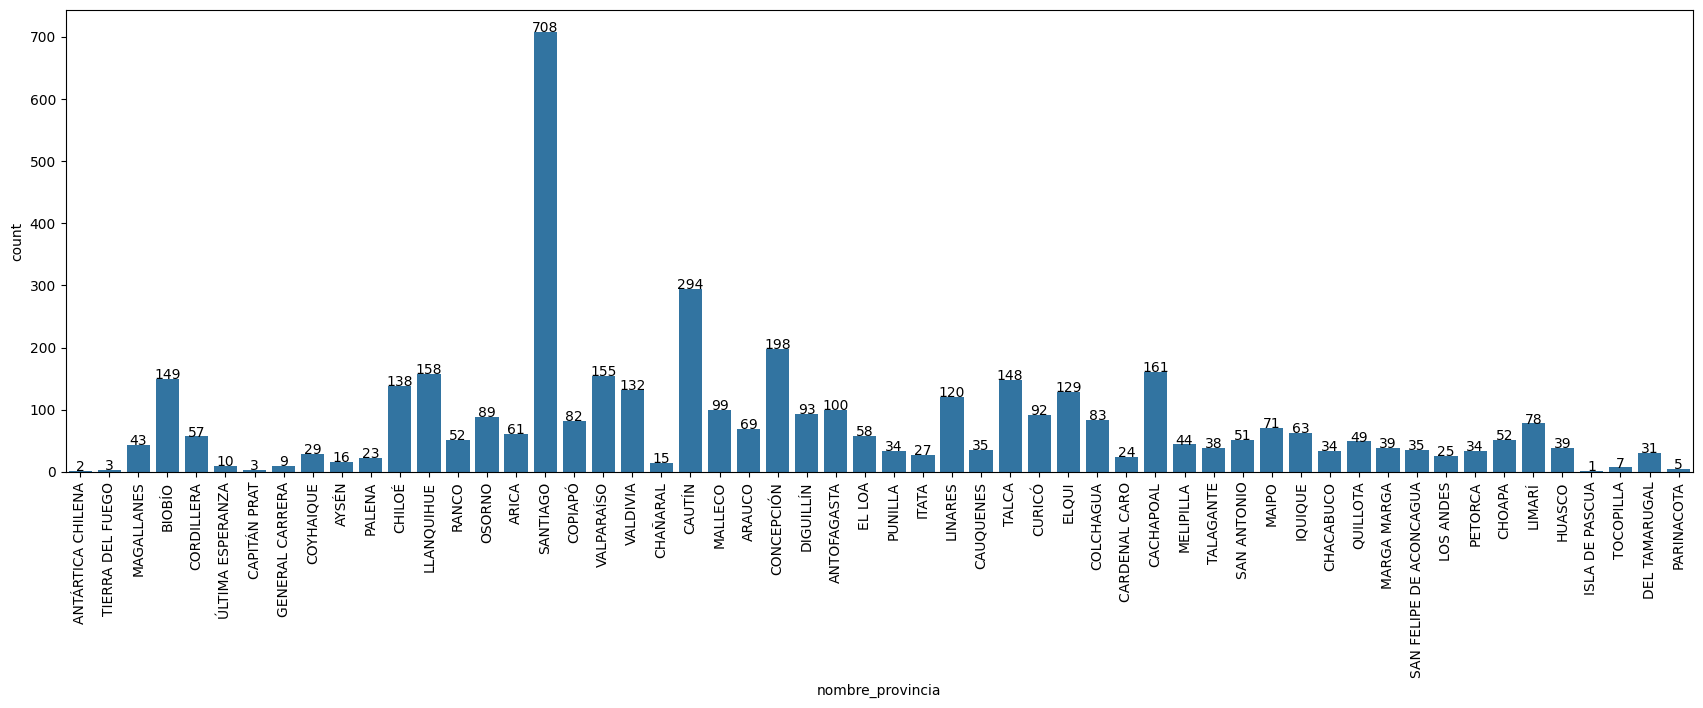

In [16]:
plt.figure(figsize=(21, 6))
ax = sns.countplot(x="nombre_provincia", data=df_hospitales_1)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.xticks(rotation=90)
plt.show()

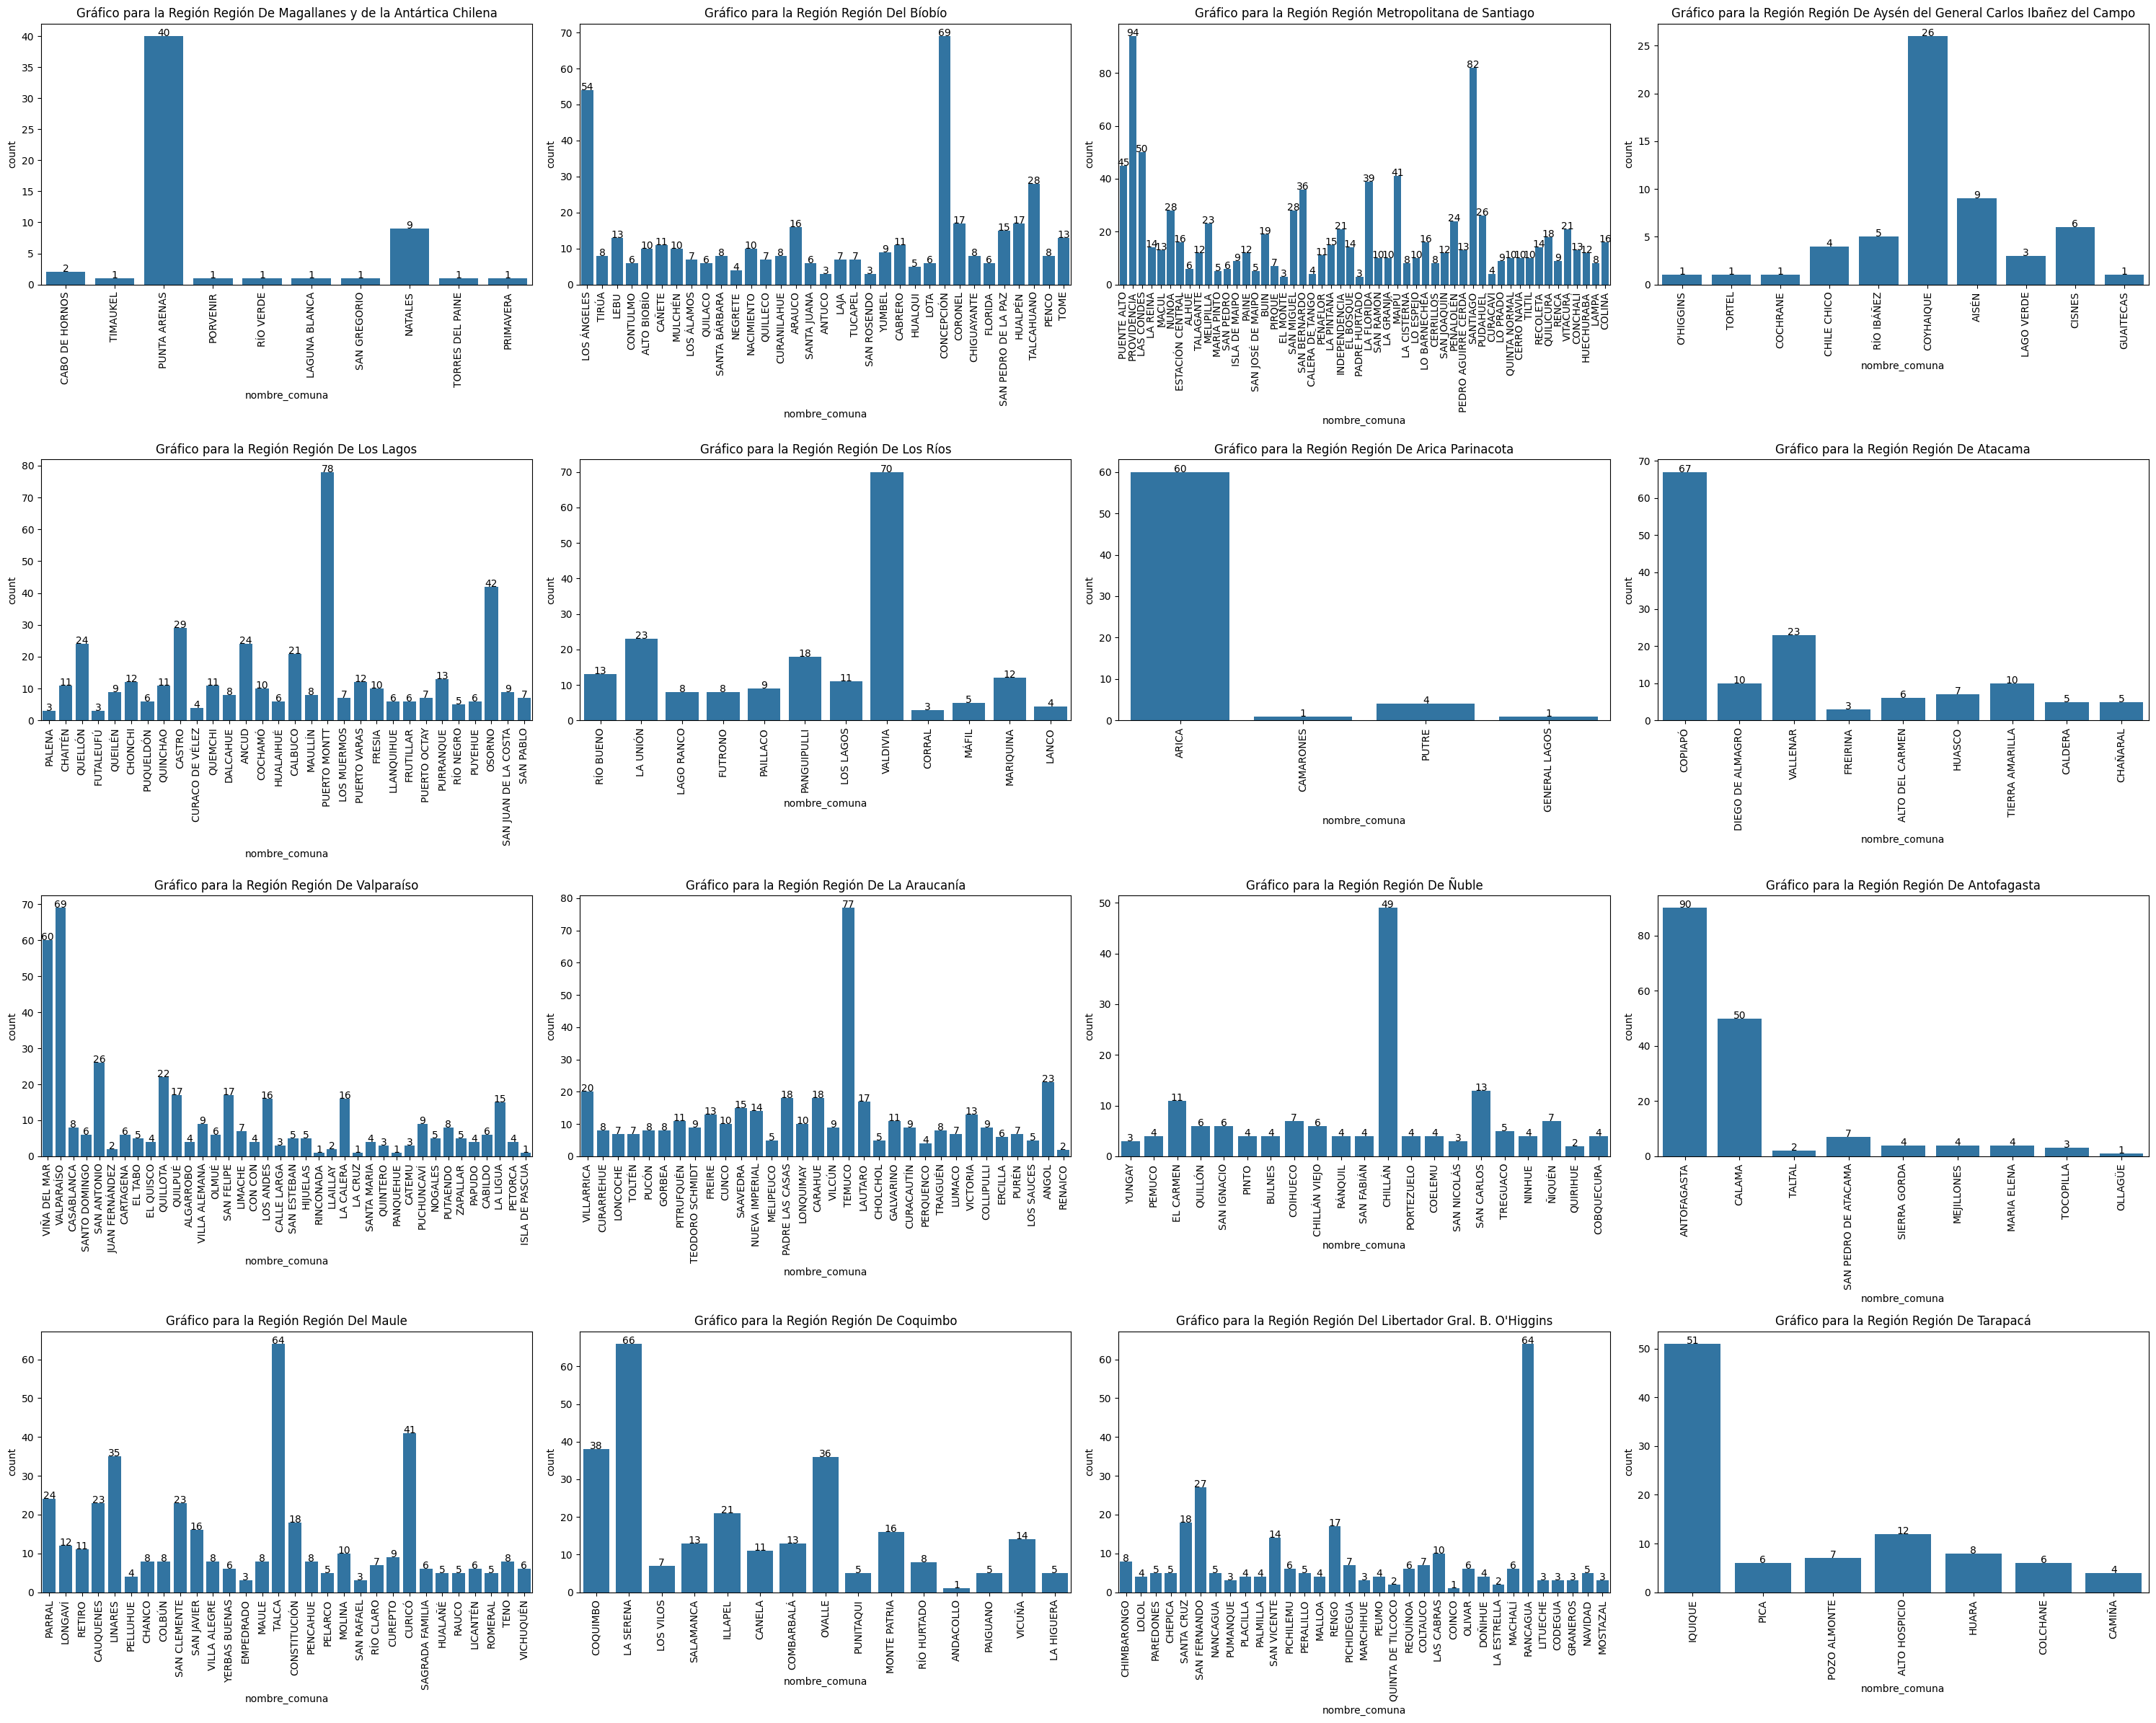

In [20]:
regiones_unicas = df_hospitales_1['nombre_región'].unique()

# Calcula el número de filas y columnas necesarias para mostrar todos los gráficos
num_regiones = len(regiones_unicas)
num_filas = (num_regiones + 3) // 4  # Divide y redondea hacia arriba

# Establece el tamaño de la figura en función del número de filas
plt.figure(figsize=(30, 6 * num_filas))

# Itera a través de las regiones y crea un gráfico para cada una
for i, region in enumerate(regiones_unicas, 1):
    # Crea el subgráfico correspondiente
    plt.subplot(num_filas, 4, i)
    
    # Crea el gráfico de barras
    ax = sns.countplot(x="nombre_comuna", data=df_hospitales_1[df_hospitales_1['nombre_región'] == region])
    
    # Añade etiquetas y título
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    plt.title(f'Gráfico para la Región {region}')
    plt.xticks(rotation=90)

# Ajusta el diseño para evitar superposiciones
plt.tight_layout()

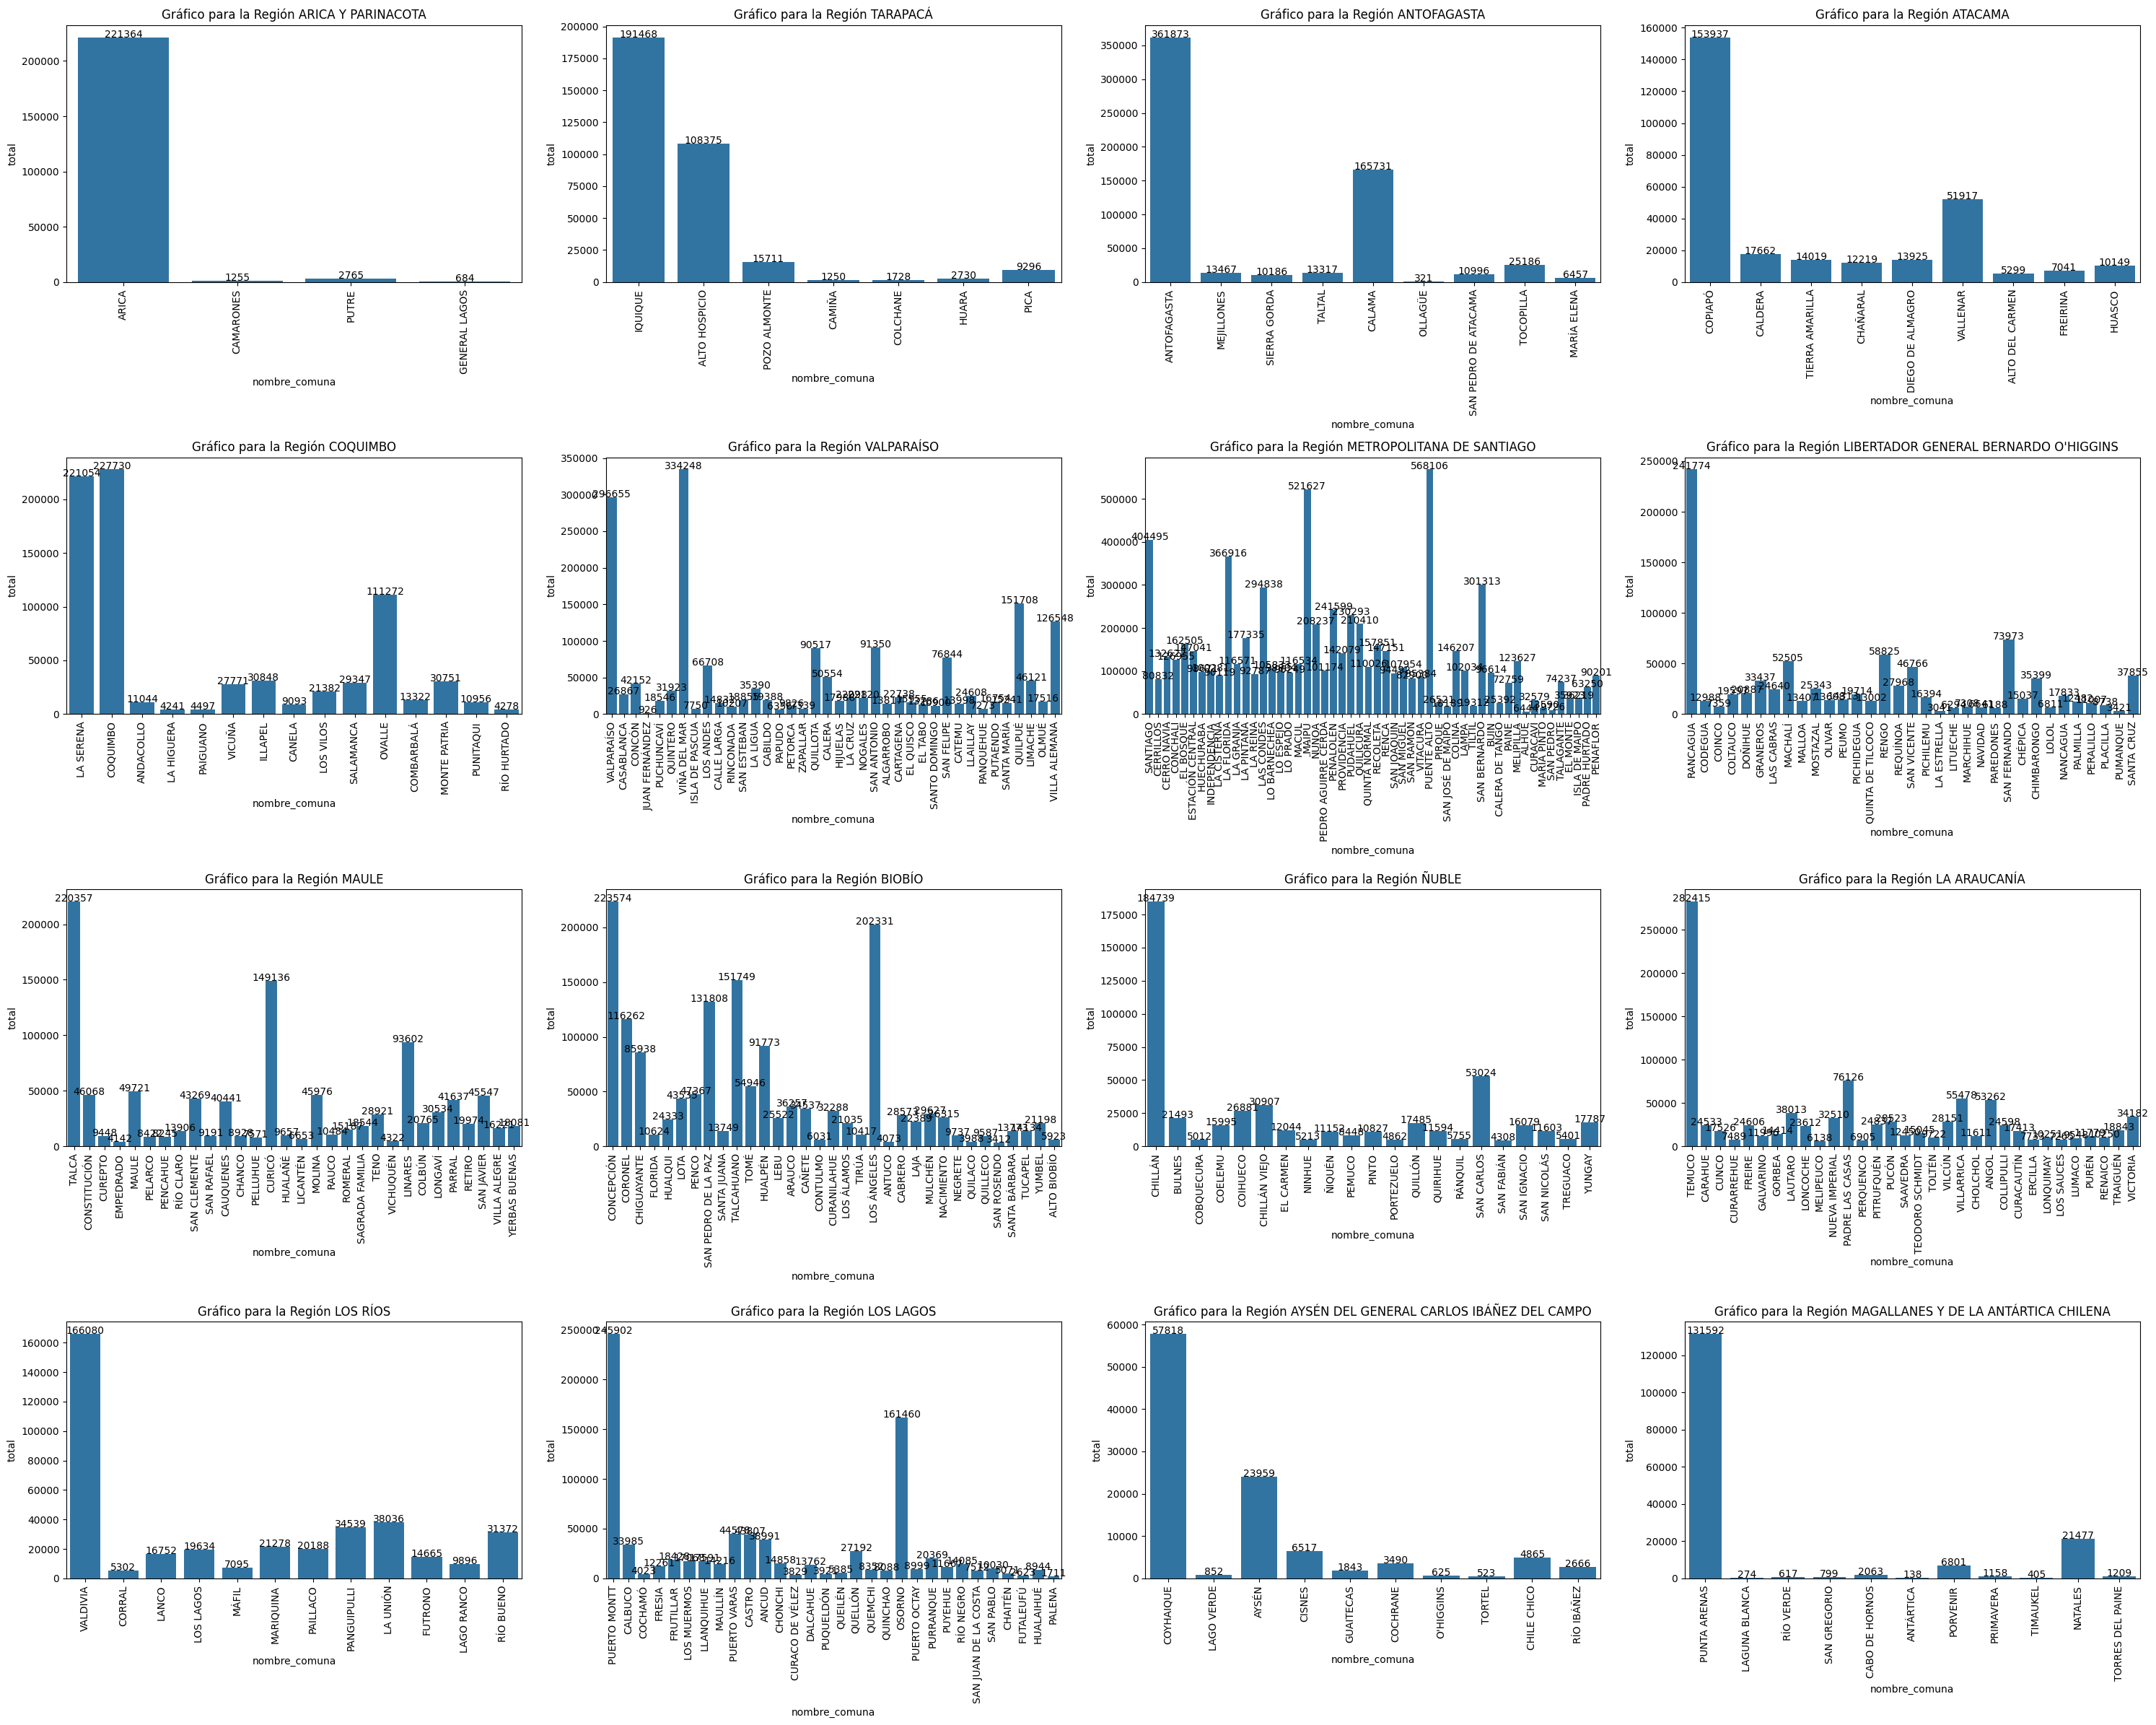

In [35]:
regiones_unicas = df_poblacion_por_comuna['nombre_región'].unique()

# Calcula el número de filas y columnas necesarias para mostrar todos los gráficos
num_regiones = len(regiones_unicas)
num_filas = (num_regiones + 3) // 4  # Divide y redondea hacia arriba

# Establece el tamaño de la figura en función del número de filas
plt.figure(figsize=(30, 6 * num_filas))

# Itera a través de las regiones y crea un gráfico para cada una
for i, region in enumerate(regiones_unicas, 1):
    # Crea el subgráfico correspondiente
    plt.subplot(num_filas, 4, i)
    
    # Crea el gráfico de barras
    ax = sns.barplot(x="nombre_comuna", y="total", data=df_poblacion_por_comuna[df_poblacion_por_comuna['nombre_región'] == region])
    
    # Añade etiquetas y título
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    plt.title(f'Gráfico para la Región {region}')
    plt.xticks(rotation=90)

# Ajusta el diseño para evitar superposiciones
plt.tight_layout()

Se puede ver que las comunas con mas hospitales tiene mas poblacion

#### Relacion entre poblacion y cantidad de hospitales

In [53]:
df_poblacion_por_comuna.columns


Index(['orden', 'nombre_región', 'código_región', 'nombre_provincia',
       'código_provincia', 'nombre_comuna', 'código_comuna', 'edad', 'hombres',
       'mujeres', 'total'],
      dtype='object')

In [54]:
df_hospitales_poblacion_comuna = pd.merge(on="código_comuna", left=df_hospitales_1, right=df_poblacion_por_comuna[["código_comuna", "total"]], how="right")
conteo = df_hospitales_poblacion_comuna['código_comuna'].value_counts()
df_hospitales_poblacion_comuna['hospitales_x_comuna'] = df_hospitales_poblacion_comuna['código_comuna'].map(conteo)
df_hospitales_poblacion_comuna.drop_duplicates(subset="código_comuna", inplace=True)
df_hospitales_poblacion_comuna.head(1)

código_vigente  código_región               nombre_región  \
0        200585.0           15.0  Región De Arica Parinacota   

   código_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                                               15.0            

  nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                       SEREMI De Arica y Parinacota           

  pertenencia_al_snss tipo_establecimiento_(unidad)  ámbito_de_funcionamiento  \
0               False                Clínica Dental  Establecimiento de Salud   

                                      nombre_oficial nivel_de_atención  ...  \
0  Centro de Especialidades Odontológicas del Nor...               NaN  ...   

   tipo_de_urgencia    latitud   longitud tipo_de_prestador_sistema_de_salud  \
0               NaN -18.482842 -70.307282                            Privado   

   nivel_de_complejidad              tipo_de_atención código_provincia  \
0   Mediana Complejidad  Atención Abierta-Ambulatoria            151.0   

  nombre_provincia   total  hospitales_x_comuna  
0            ARICA  221364                   60  

[1 rows x 23 columns]

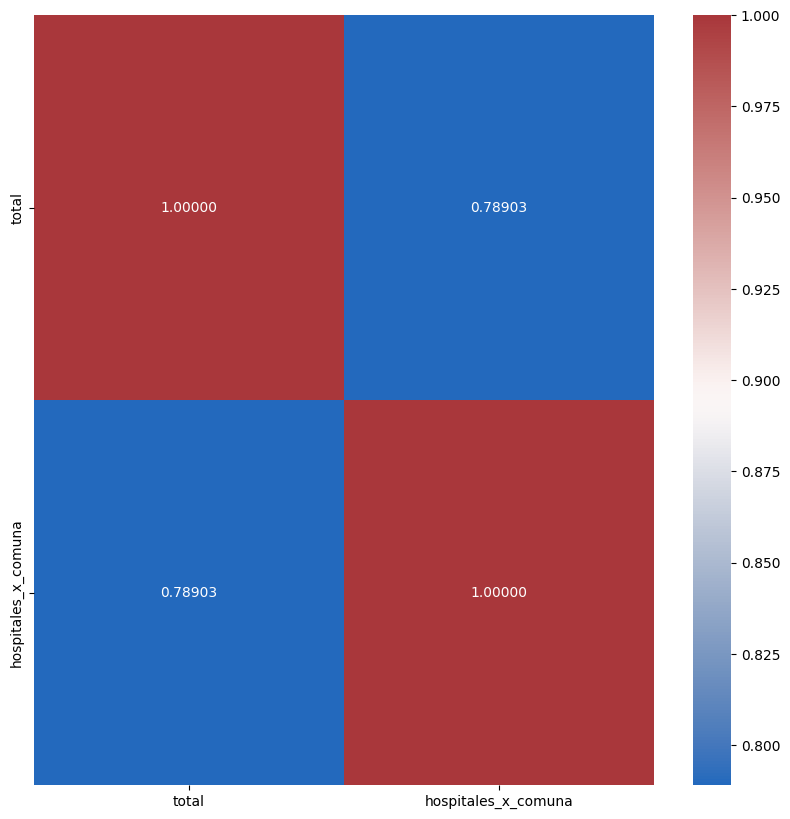

In [57]:
plt.figure(figsize=(10, 10))

correlation_matrix = df_hospitales_poblacion_comuna[["total", "hospitales_x_comuna"]].corr().round(5)

sns.heatmap(correlation_matrix, annot=True,  fmt=".5f", cmap="vlag")

plt.show()

Existe un correlacion alta entre total de personas y cantidad de hospitales

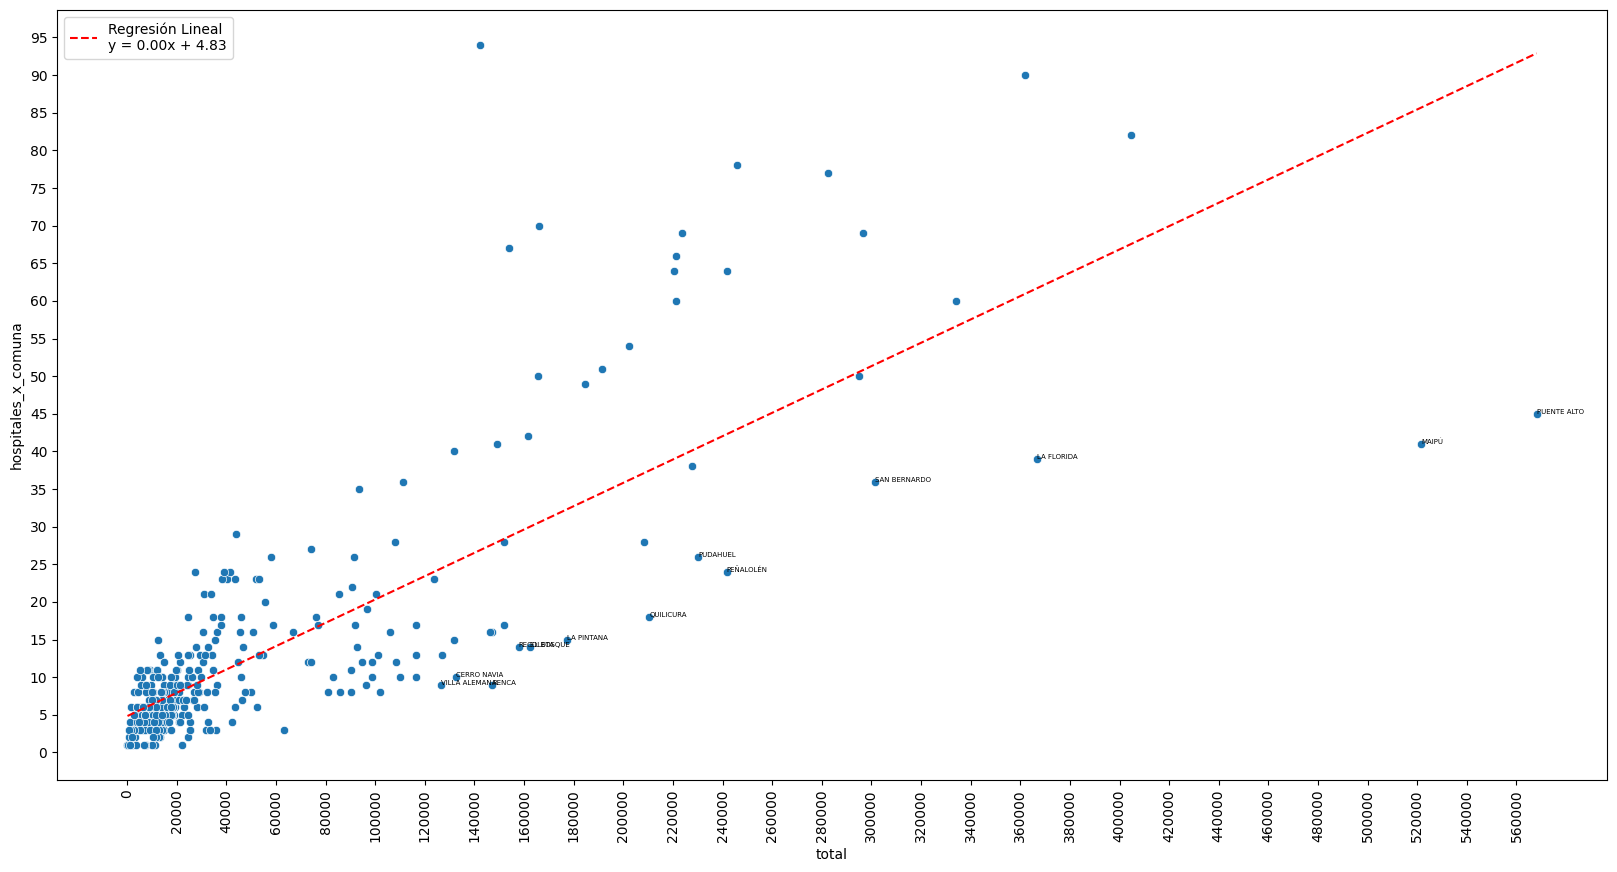

In [81]:
import numpy as np

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x=df_hospitales_poblacion_comuna["total"], y=df_hospitales_poblacion_comuna["hospitales_x_comuna"])

coefficients = np.polyfit(df_hospitales_poblacion_comuna["total"], df_hospitales_poblacion_comuna["hospitales_x_comuna"], 1)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(df_hospitales_poblacion_comuna["total"]), max(df_hospitales_poblacion_comuna["total"]), 100)
y_values = polynomial(x_values)

plt.plot(x_values, y_values, color='red', linestyle='--', label=f'Regresión Lineal\ny = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')

distancia = 13

for i, txt in enumerate(df_hospitales_poblacion_comuna["nombre_comuna"].unique()):
    d = -1*(df_hospitales_poblacion_comuna["hospitales_x_comuna"].iloc[i] - polynomial(df_hospitales_poblacion_comuna["total"].iloc[i]))
    if d > distancia:
        ax.annotate(txt, (df_hospitales_poblacion_comuna["total"].iloc[i], df_hospitales_poblacion_comuna["hospitales_x_comuna"].iloc[i]), fontsize=8)


plt.yticks(range(0, max(df_hospitales_poblacion_comuna["hospitales_x_comuna"]) + 5, 5))
plt.xticks(range(0, max(df_hospitales_poblacion_comuna["total"]) + 10_000, 20_000), rotation=90)

plt.xticks(rotation=90)
plt.legend() 
plt.show()


In [73]:
df_km2 = pd.read_csv("../database/tabla_wikipedia.csv")
df_km2.drop(columns="Unnamed: 2", inplace=True)
nuevos_nombres = {columna: modificar_nombre_columna(columna) for columna in df_km2.columns}
df_km2.rename(columns=nuevos_nombres, inplace=True)
df_km2 = df_km2[["superficie_(km²)", "cut_(código_único_territorial)"]]
df_km2["superficie_(km²)"] = df_km2["superficie_(km²)"].str.replace(".", "").str.replace(",", ".").astype("float")
df_km2

superficie_(km²)  cut_(código_único_territorial)
0              4799.4                           15101
1              3927.0                           15102
2              5902.5                           15201
3              2244.4                           15202
4              2242.1                            1101
..                ...                             ...
341             126.0                           13601
342             118.0                           13602
343             189.0                           13603
344             808.0                           13604
345              69.0                           13605

[346 rows x 2 columns]

In [85]:
# df_hospitales_poblacion_comuna["densidad"] = df_hospitales_poblacion_comuna["hospitales_x_comuna"] / (df_hospitales_poblacion_comuna["total"] / 10_000)
densidad = df_hospitales_poblacion_comuna
densidad = pd.merge(left_on="código_comuna", right_on="cut_(código_único_territorial)",right=df_km2, left=densidad)

densidad["densidad_hospital_x_poblacion"] = densidad["hospitales_x_comuna"] / densidad["total"]
densidad["densidad_hospital_x_km2"] = densidad["hospitales_x_comuna"] / densidad["superficie_(km²)"]
densidad["densidad_poblacion"] = densidad["total"] / densidad["superficie_(km²)"]
densidad

código_vigente  código_región  \
0          200585.0           15.0   
1          101406.0           15.0   
2          101407.0           15.0   
3          101404.0           15.0   
4          200540.0            1.0   
..              ...            ...   
341        126102.0           12.0   
342        201436.0           12.0   
343        126412.0           12.0   
344        200472.0           12.0   
345        126400.0           12.0   

                                      nombre_región  \
0                        Región De Arica Parinacota   
1                        Región De Arica Parinacota   
2                        Región De Arica Parinacota   
3                        Región De Arica Parinacota   
4                                Región De Tarapacá   
..                                              ...   
341  Región De Magallanes y de la Antártica Chilena   
342  Región De Magallanes y de la Antártica Chilena   
343  Región De Magallanes y de la Antártica Chilena   
344  Región De Magallanes y de la Antártica Chilena   
345  Región De Magallanes y de la Antártica Chilena   

     código_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                                                 15.0            
1                                                  1.0            
2                                                  1.0            
3                                                  1.0            
4                                                  1.0            
..                                                 ...            
341                                               26.0            
342                                               26.0            
343                                               26.0            
344                                               12.0            
345                                               26.0            

    nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)  \
0                         SEREMI De Arica y Parinacota           
1                 Servicio de Salud Arica y Parinacota           
2                 Servicio de Salud Arica y Parinacota           
3                 Servicio de Salud Arica y Parinacota           
4                                   SEREMI De Tarapacá           
..                                                 ...           
341                       Servicio de Salud Magallanes           
342                       Servicio de Salud Magallanes           
343                       Servicio de Salud Magallanes           
344        SEREMI De Magallanes y la Antártica Chilena           
345                       Servicio de Salud Magallanes           

    pertenencia_al_snss tipo_establecimiento_(unidad)  \
0                 False                Clínica Dental   
1                  True    Posta de Salud Rural (PSR)   
2                  True    Posta de Salud Rural (PSR)   
3                  True    Posta de Salud Rural (PSR)   
4                 False                Clínica Dental   
..                  ...                           ...   
341                True                      Hospital   
342                True    Posta de Salud Rural (PSR)   
343                True    Posta de Salud Rural (PSR)   
344               False           Laboratorio Clínico   
345                True    Posta de Salud Rural (PSR)   

     ámbito_de_funcionamiento  \
0    Establecimiento de Salud   
1    Establecimiento de Salud   
2    Establecimiento de Salud   
3    Establecimiento de Salud   
4    Establecimiento de Salud   
..                        ...   
341  Establecimiento de Salud   
342  Establecimiento de Salud   
343  Establecimiento de Salud   
344  Establecimiento de Salud   
345  Establecimiento de Salud   

                                        nombre_oficial nivel_de_atención  ...  \
0    Centro de Especialidades Odontológicas del Nor...               NaN  ...   
1                           Posta de Salud Ru

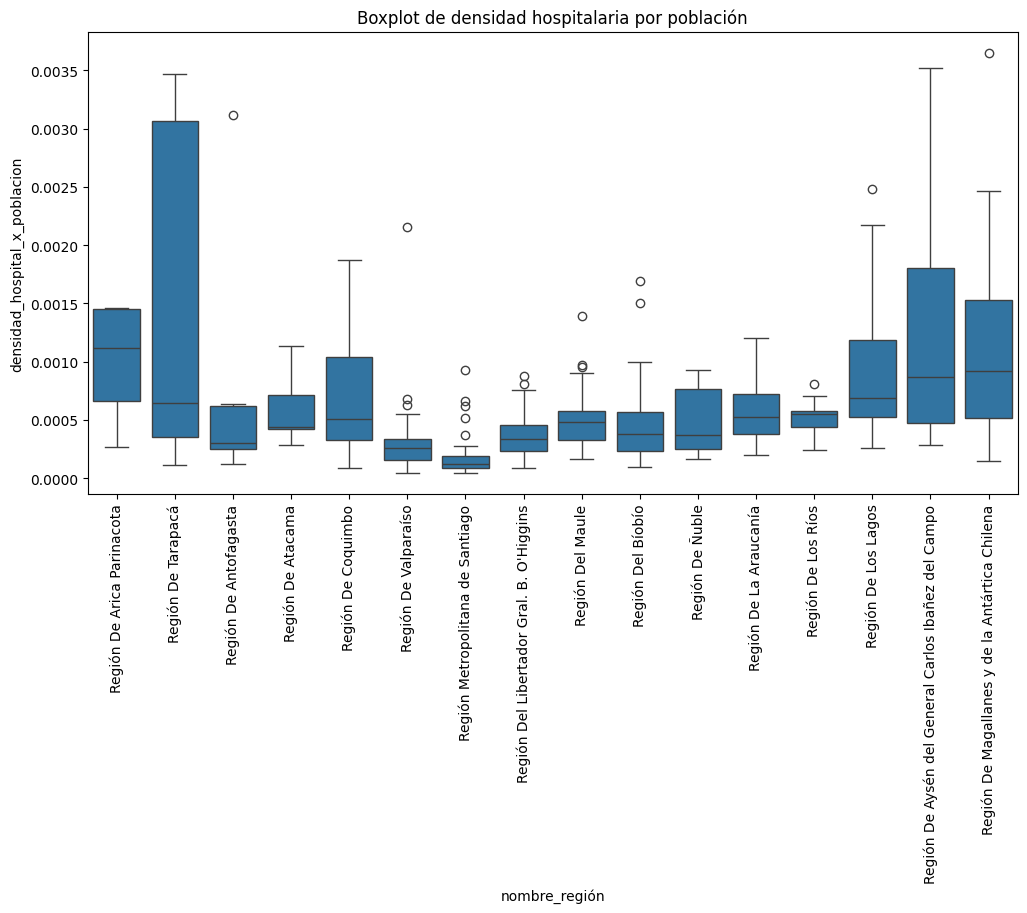

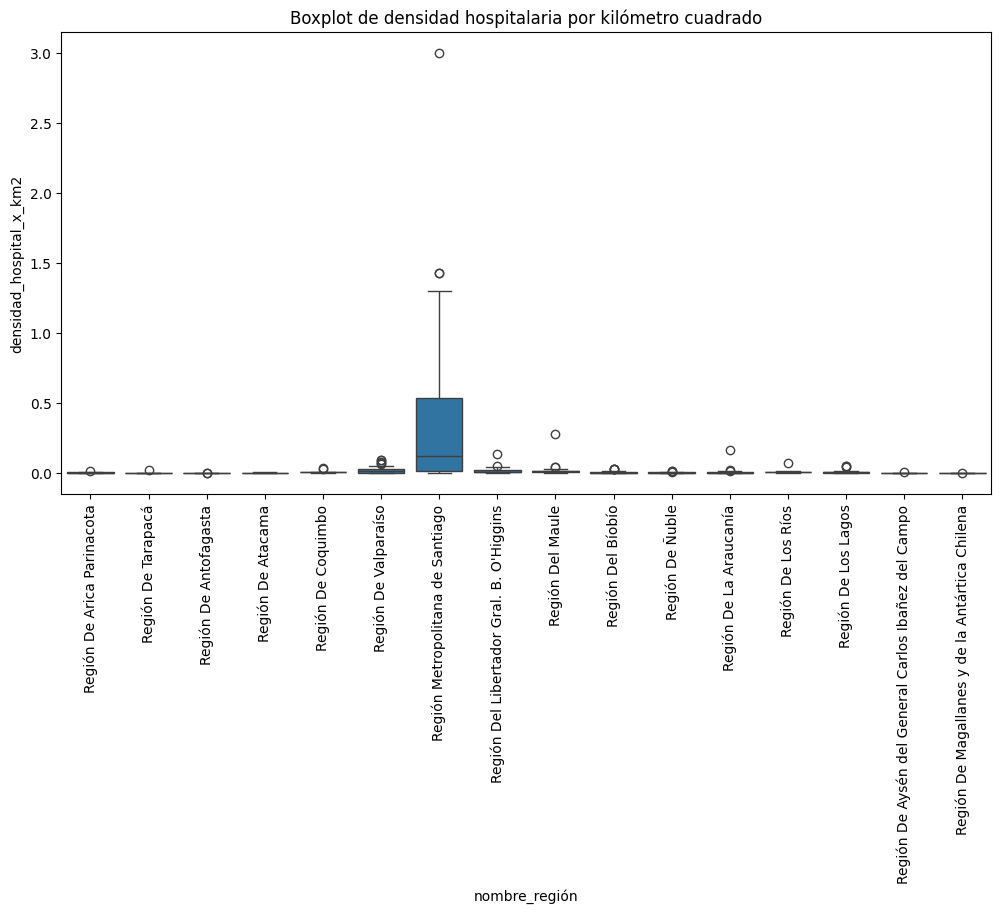

In [93]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="nombre_región", y="densidad_hospital_x_poblacion", data=densidad)
plt.title("Boxplot de densidad hospitalaria por población")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="nombre_región", y="densidad_hospital_x_km2", data=densidad)
plt.title("Boxplot de densidad hospitalaria por kilómetro cuadrado")
plt.xticks(rotation=90)

plt.show()



In [101]:
gdf = gpd.read_file('../maps/Comunas.zip')
gdf = pd.merge(left=gdf, right=densidad, left_on="cod_comuna", right_on="código_comuna")
gdf = gdf[(gdf["cod_comuna"] != 5201) & (gdf["cod_comuna"] != 5104)]
scaler = MinMaxScaler()
gdf["densidad_hospital_x_km2_n"] = scaler.fit_transform(gdf[['densidad_hospital_x_km2']])
gdf["densidad_hospital_x_poblacion_n"] = scaler.fit_transform(gdf[['densidad_hospital_x_poblacion']])

In [99]:
gdf.columns


Index(['objectid', 'shape_leng', 'dis_elec', 'cir_sena', 'cod_comuna',
       'codregion', 'st_area_sh', 'st_length_', 'Region', 'Comuna',
       'Provincia', 'geometry', 'código_vigente', 'código_región',
       'nombre_región',
       'código_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'nombre_dependencia_jerárquica_(seremi_/_servicio_de_salud)',
       'pertenencia_al_snss', 'tipo_establecimiento_(unidad)',
       'ámbito_de_funcionamiento', 'nombre_oficial', 'nivel_de_atención',
       'código_comuna', 'nombre_comuna', 'tiene_servicio_de_urgencia',
       'tipo_de_urgencia', 'latitud', 'longitud',
       'tipo_de_prestador_sistema_de_salud', 'nivel_de_complejidad',
       'tipo_de_atención', 'código_provincia', 'nombre_provincia', 'total',
       'hospitales_x_comuna', 'superficie_(km²)',
       'cut_(código_único_territorial)', 'densidad_hospital_x_poblacion',
       'densidad_hospital_x_km2', 'densidad_poblacion'],
      dtype='object')

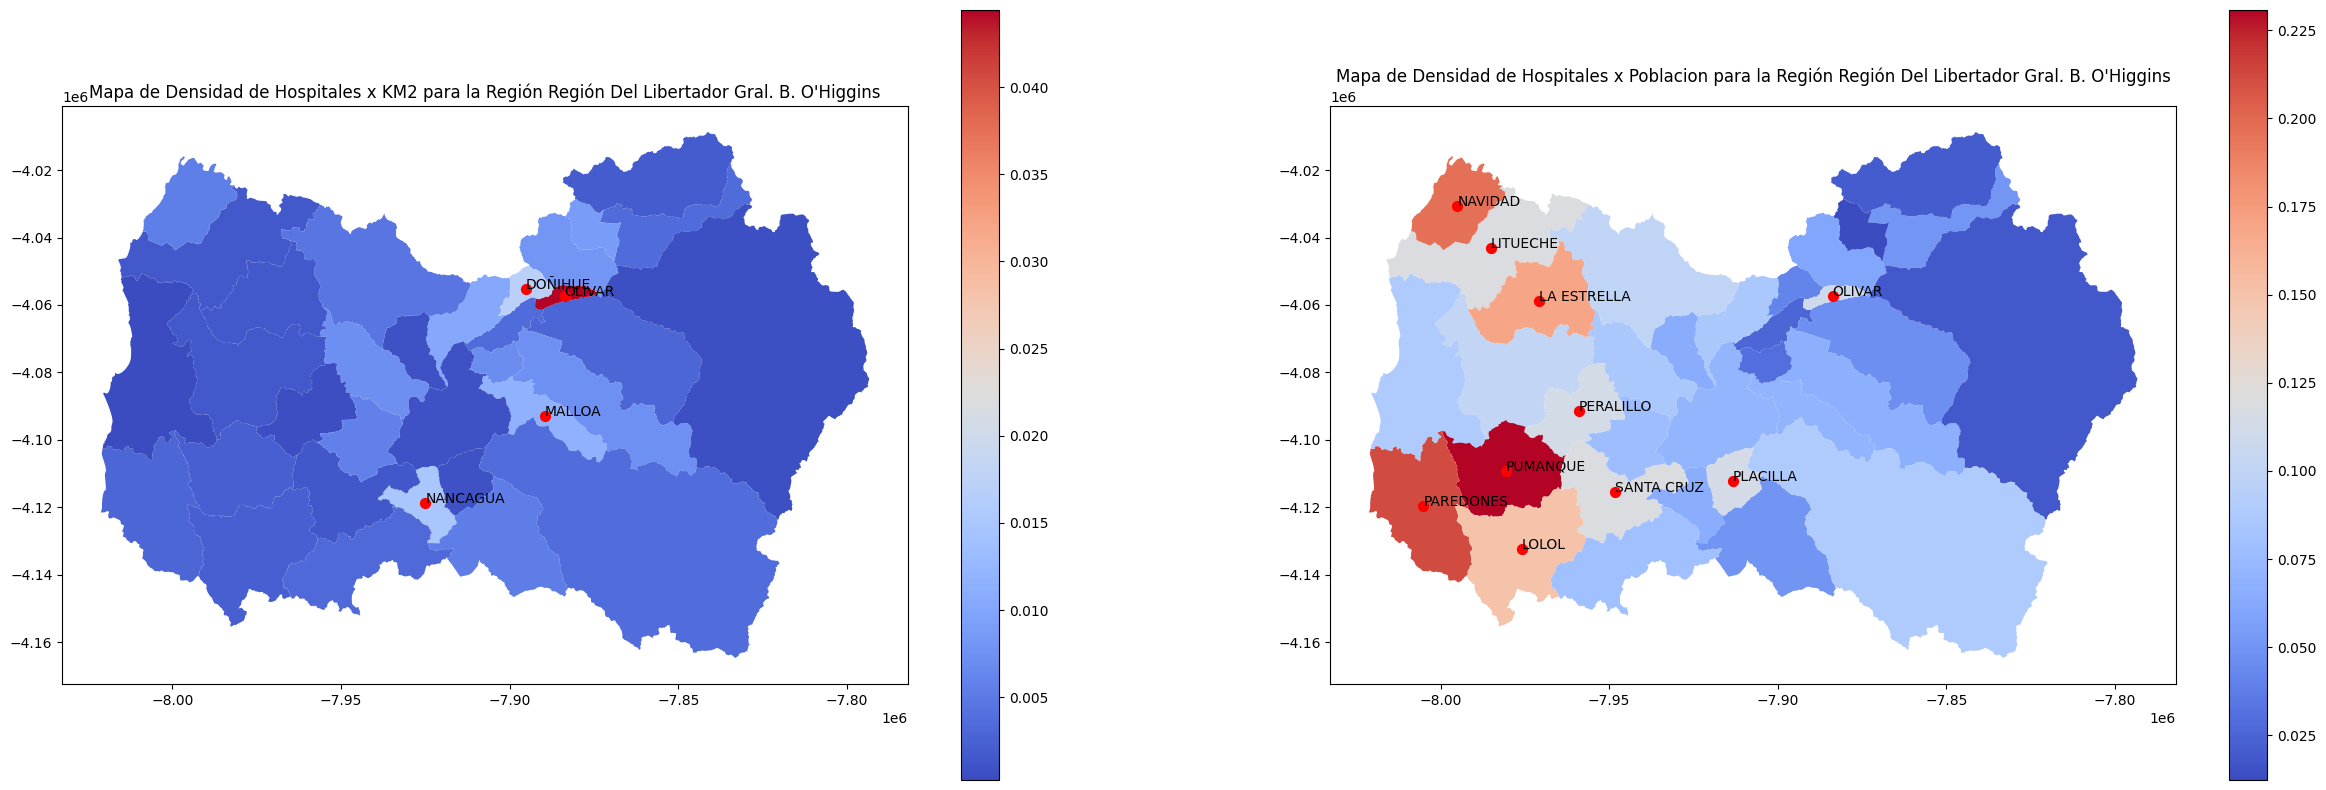

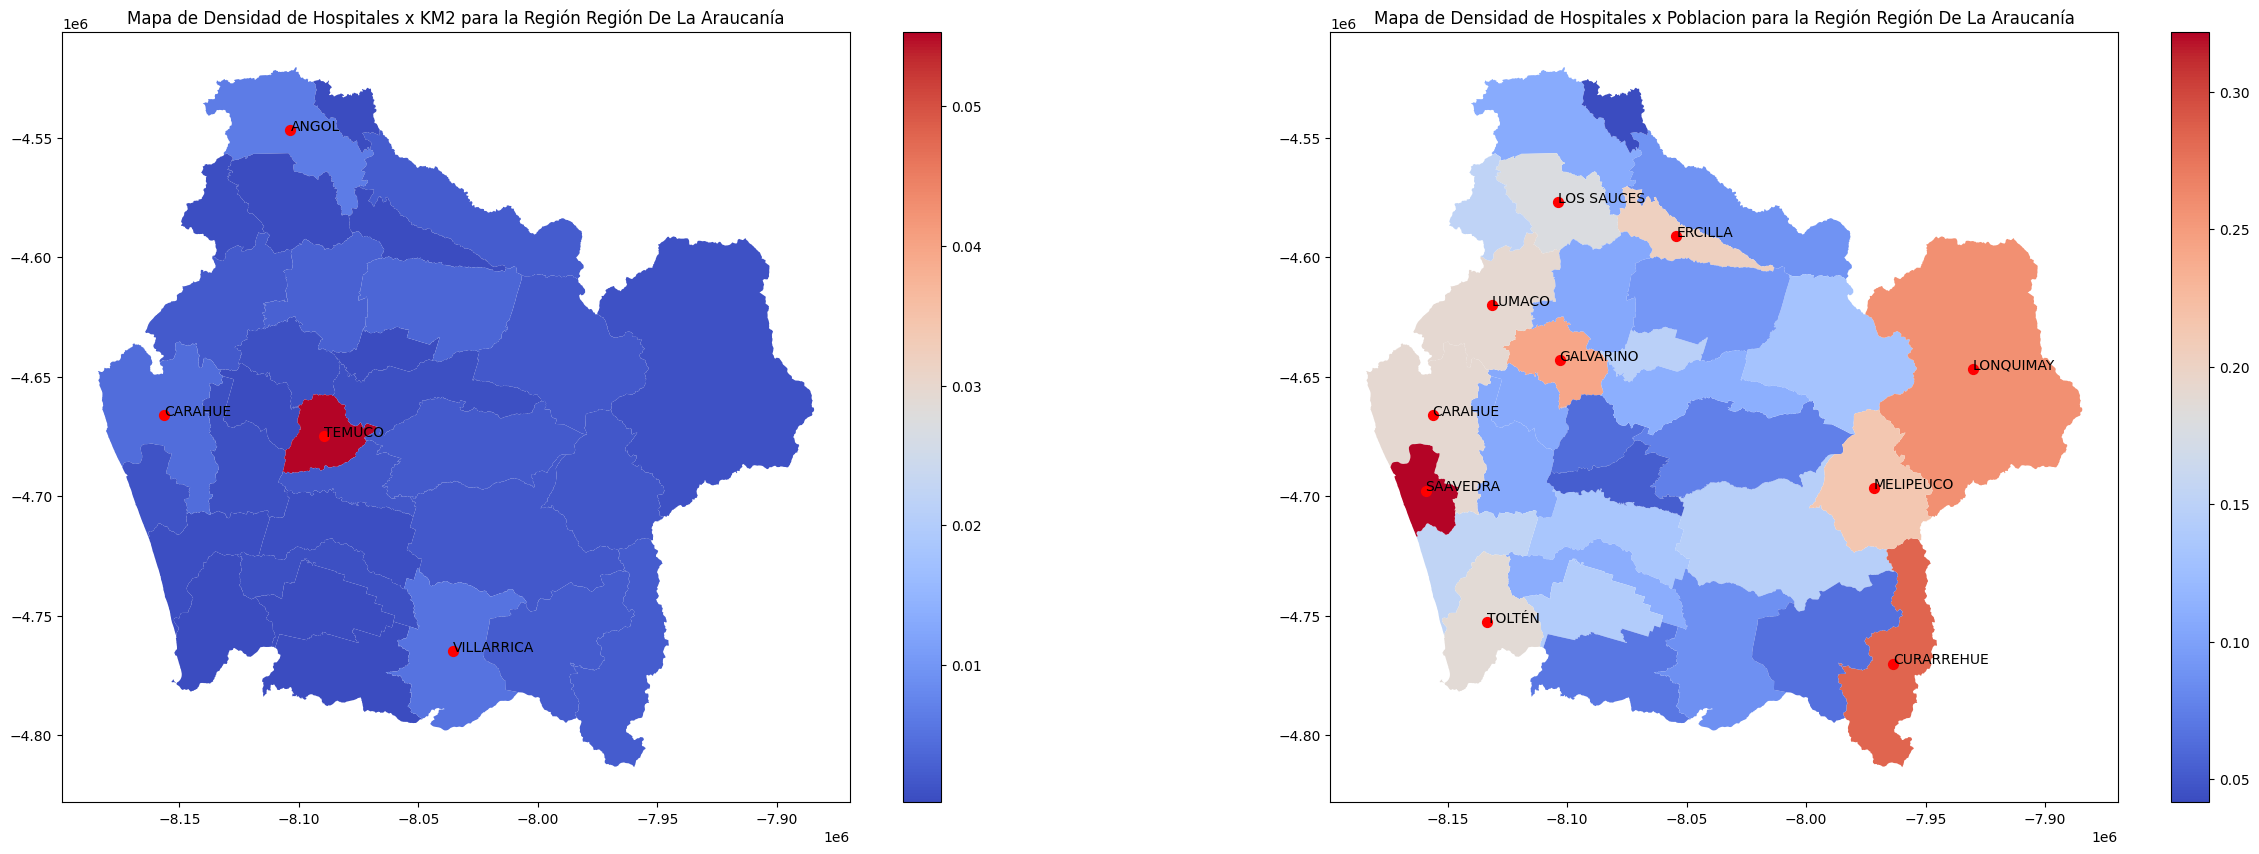

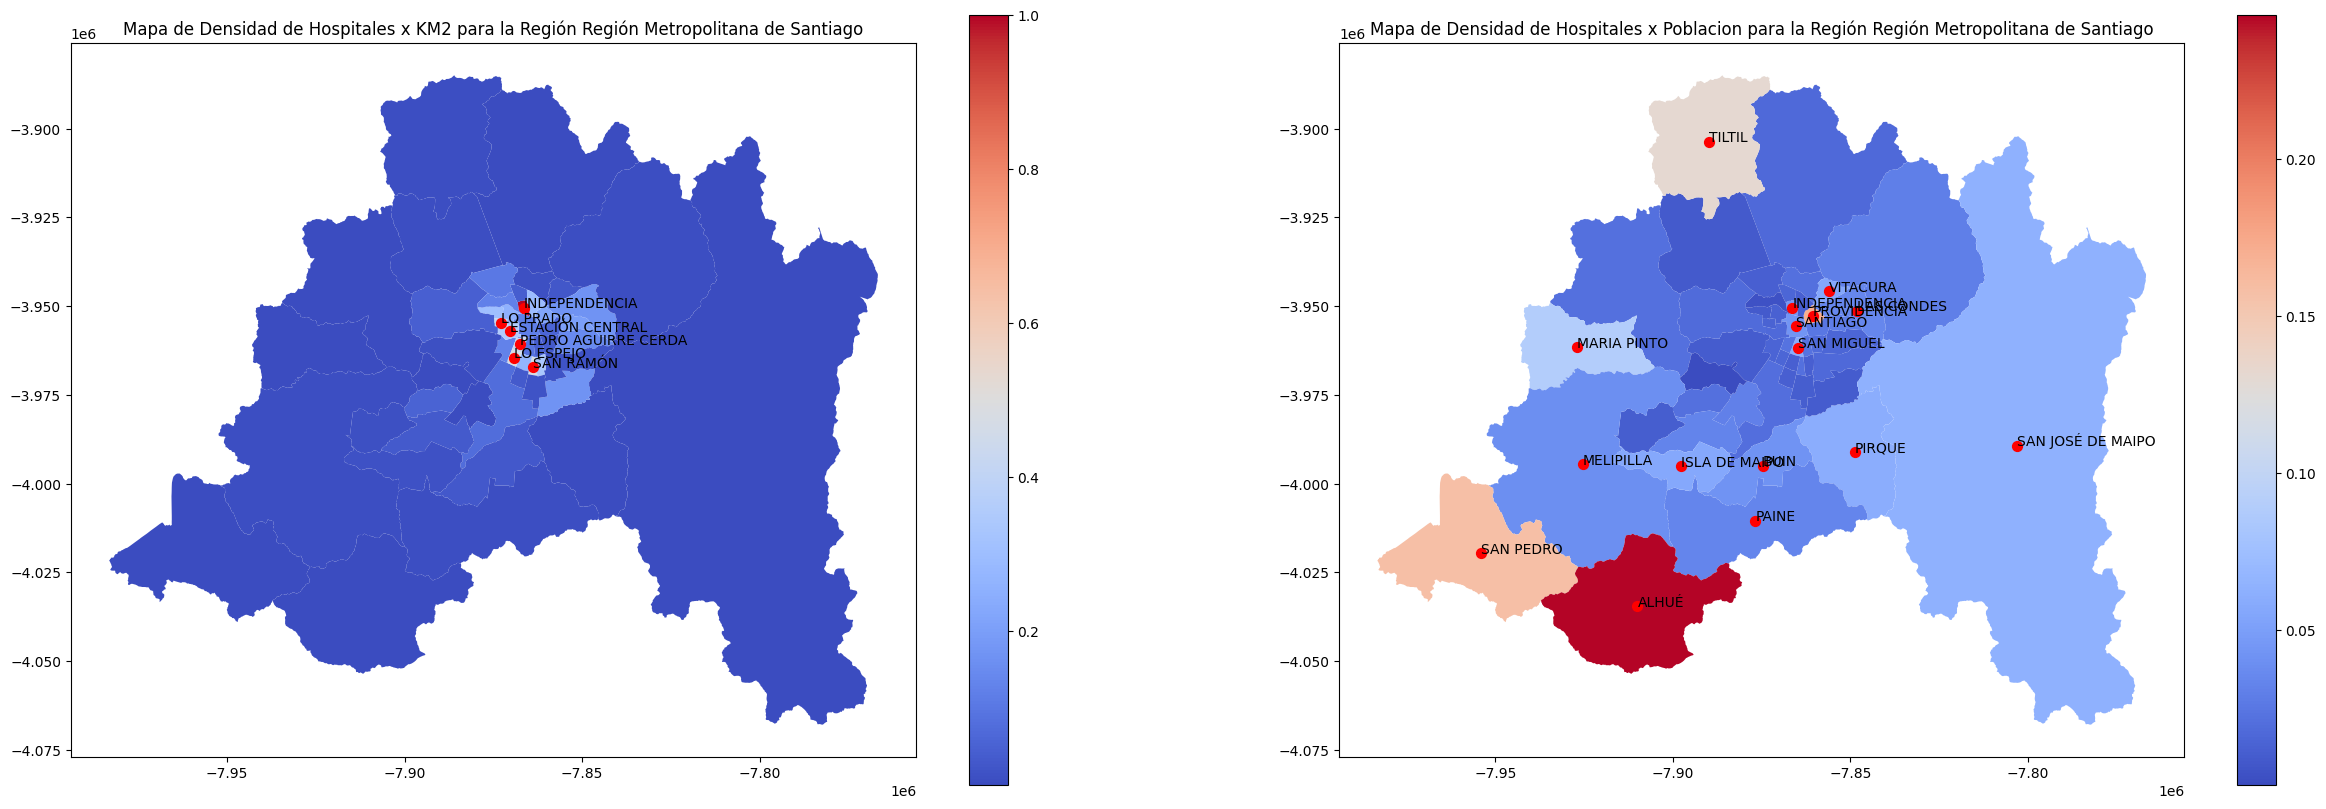

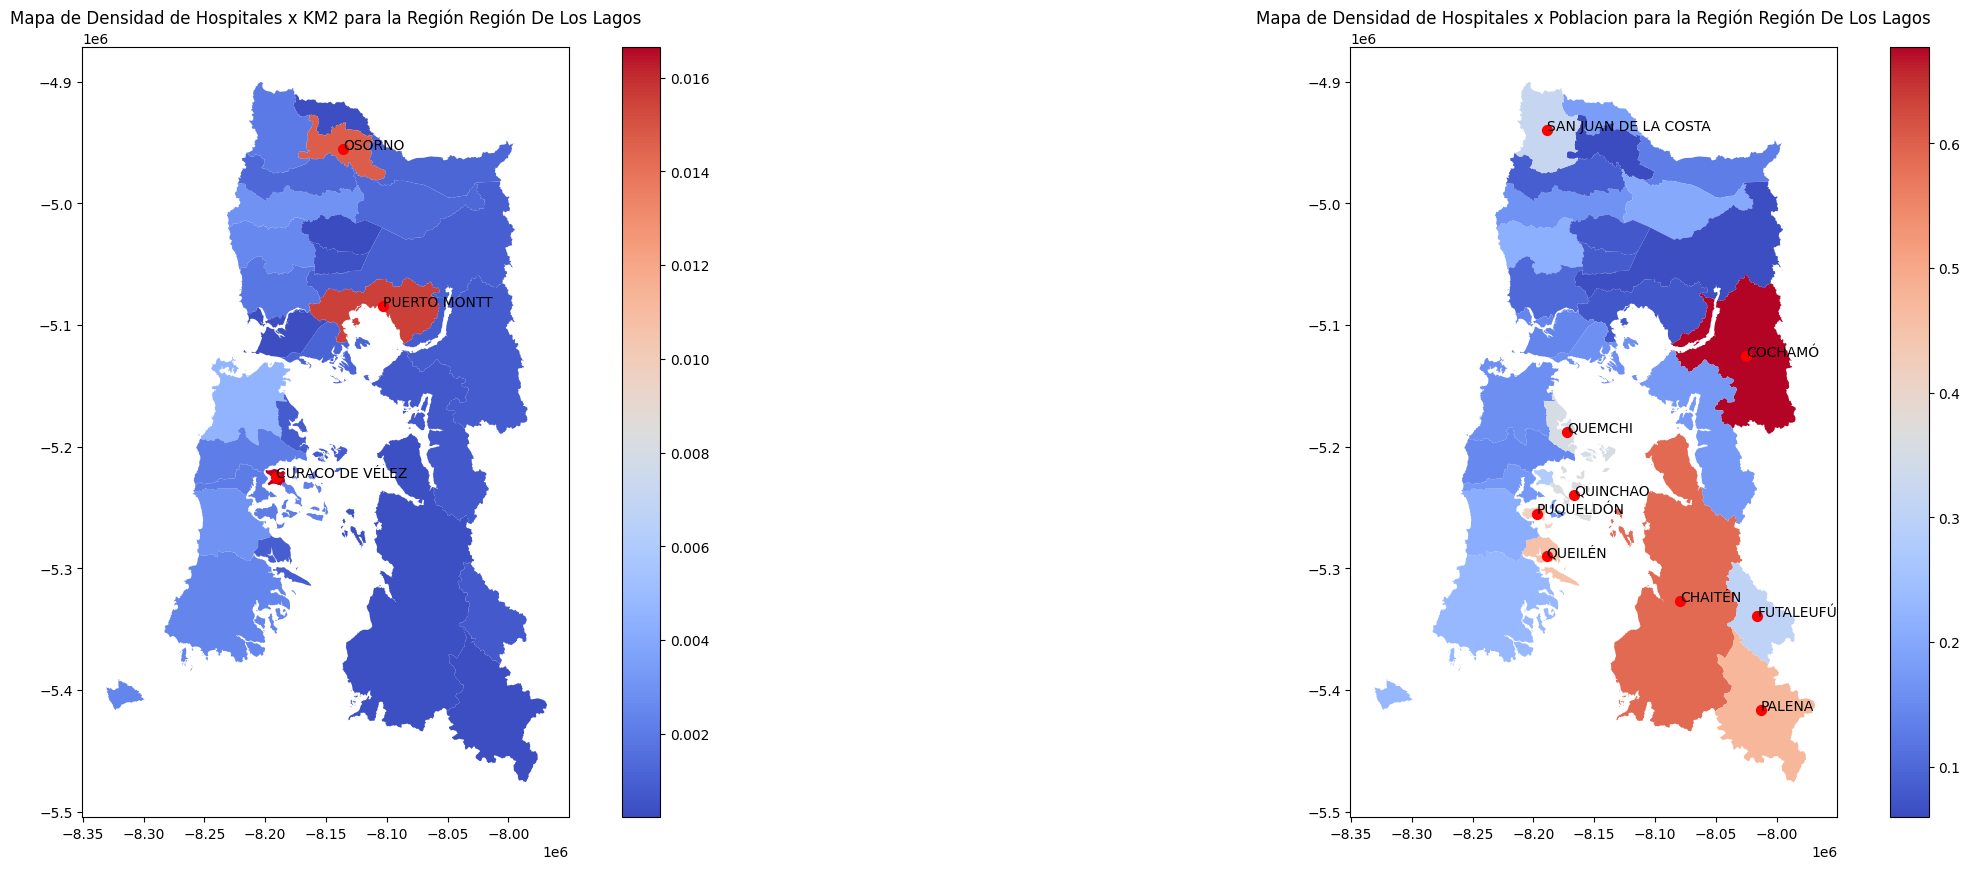

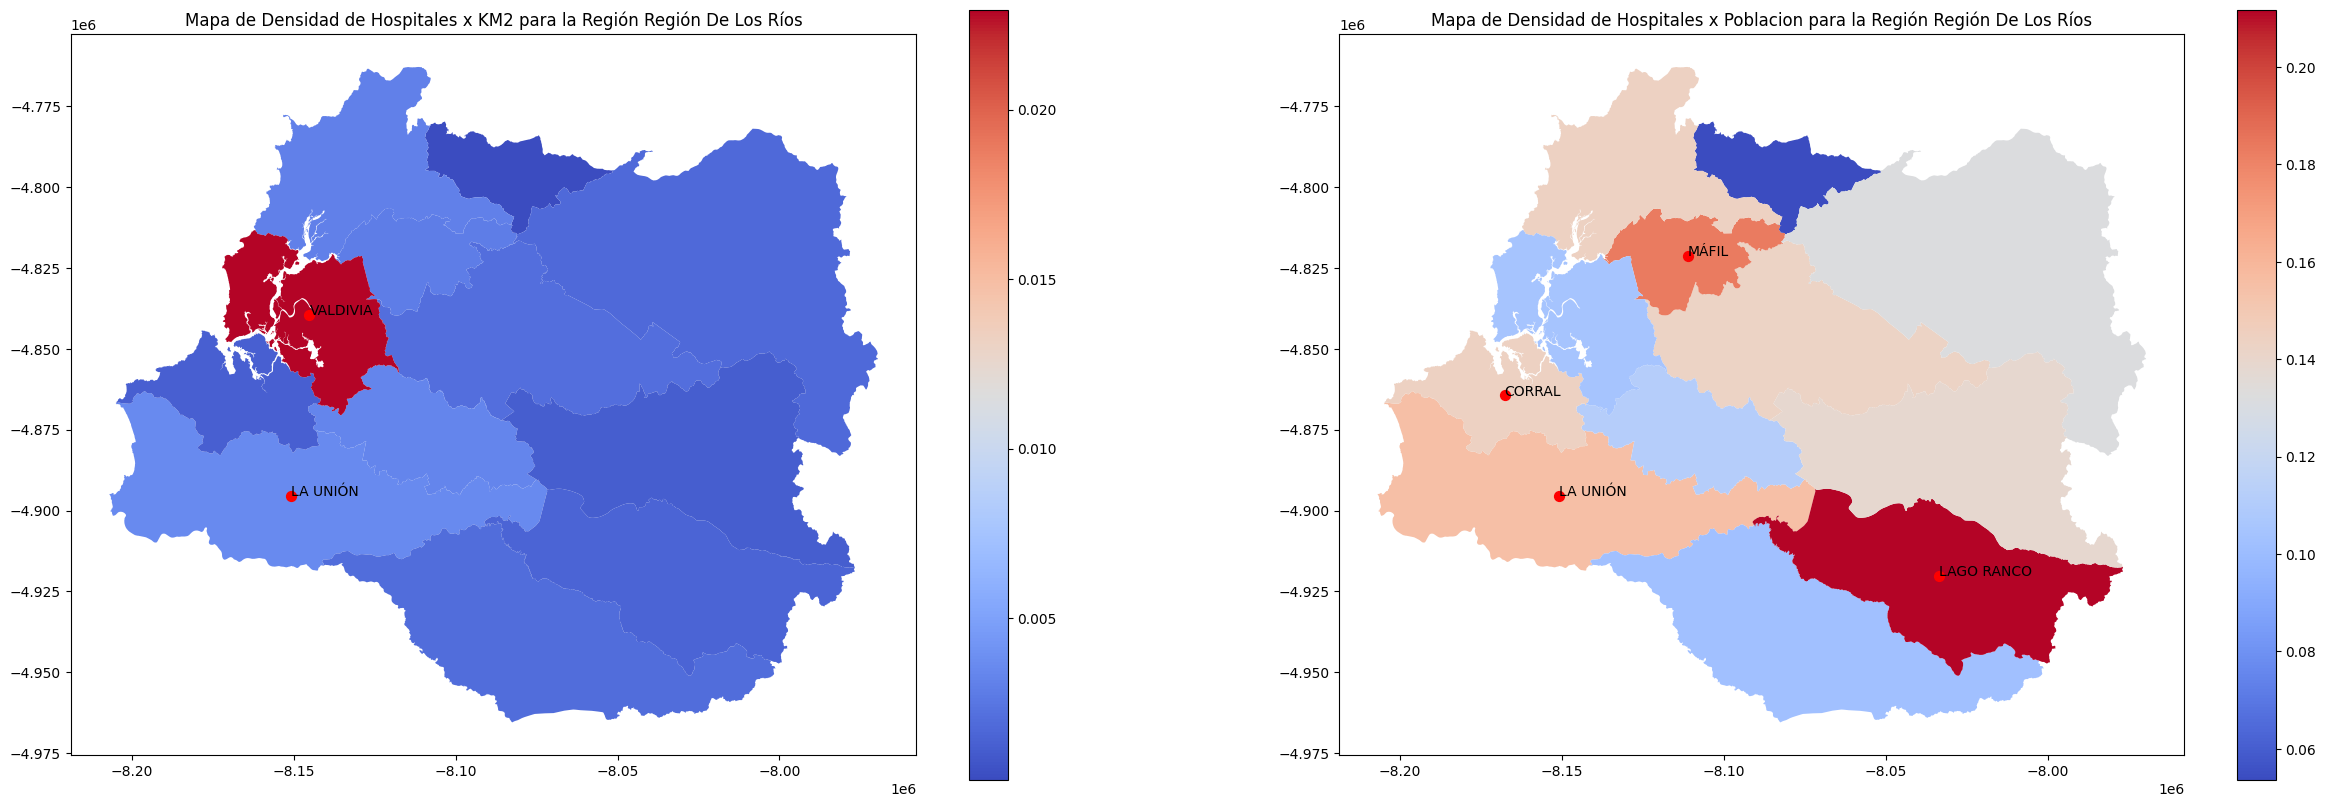

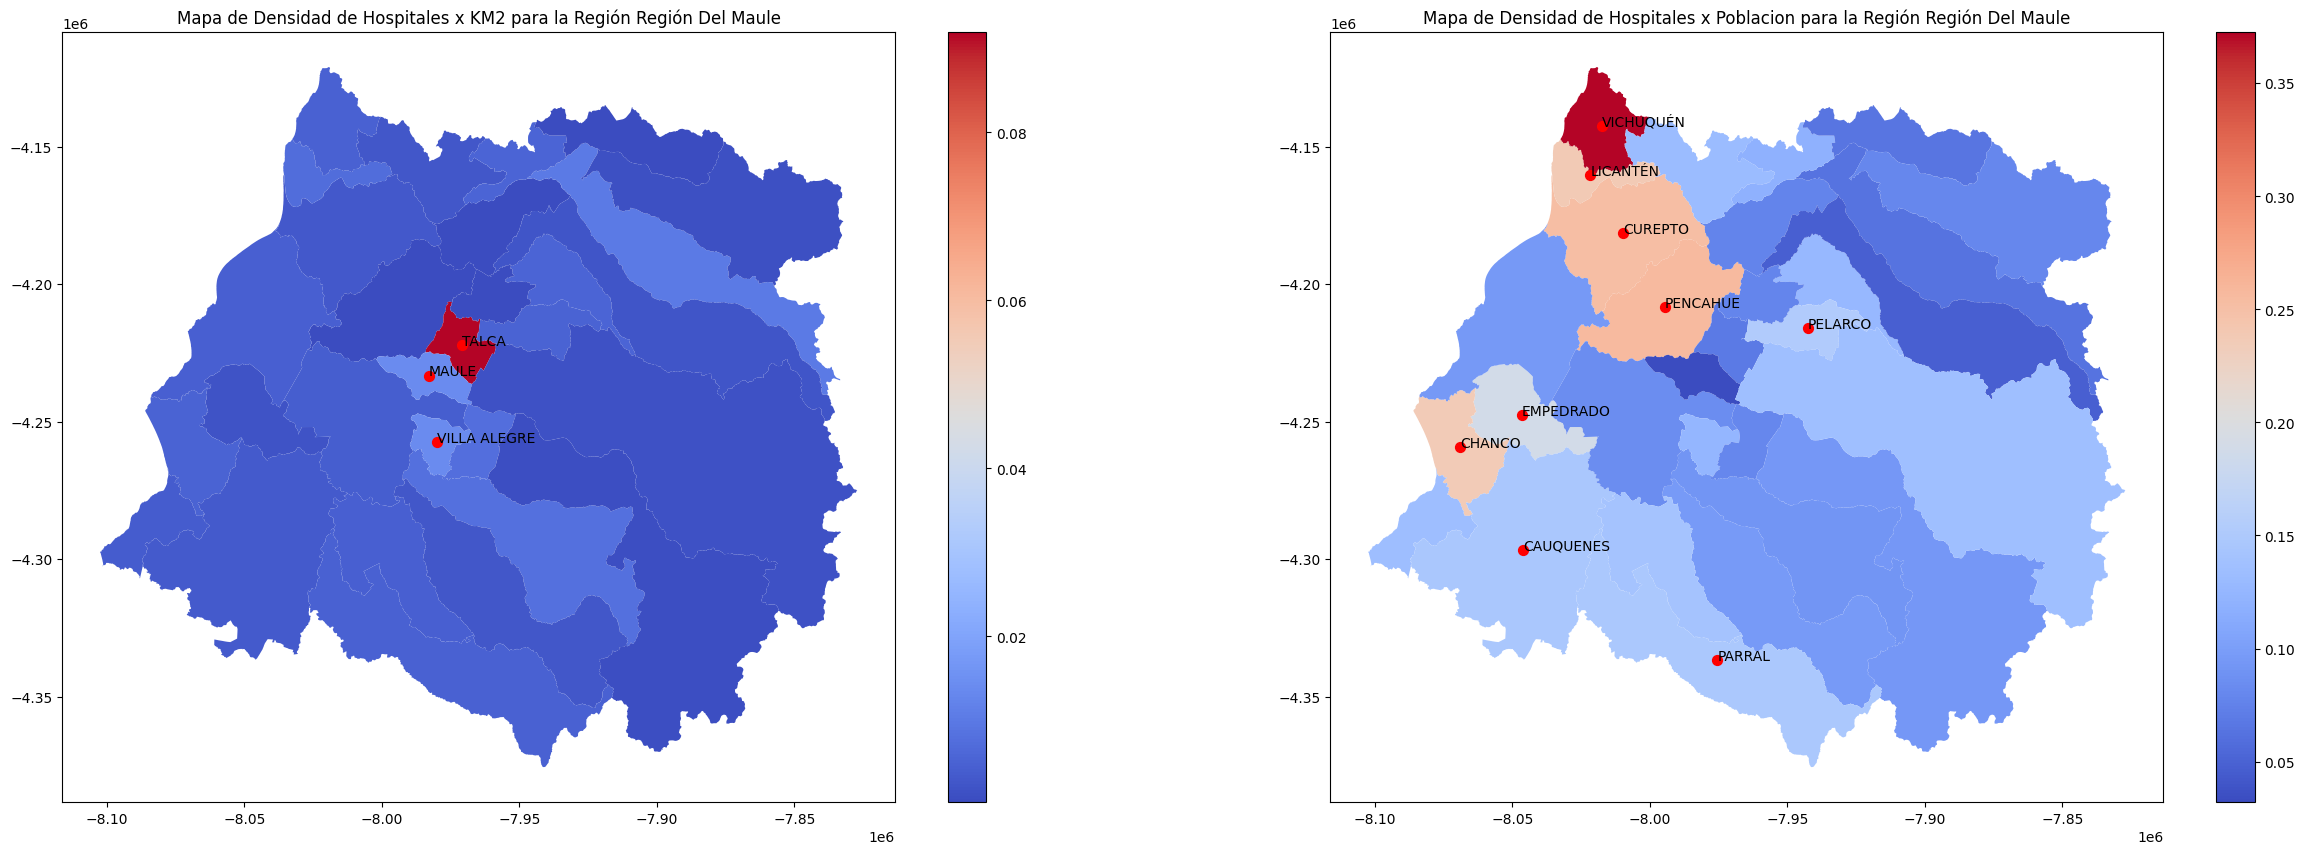

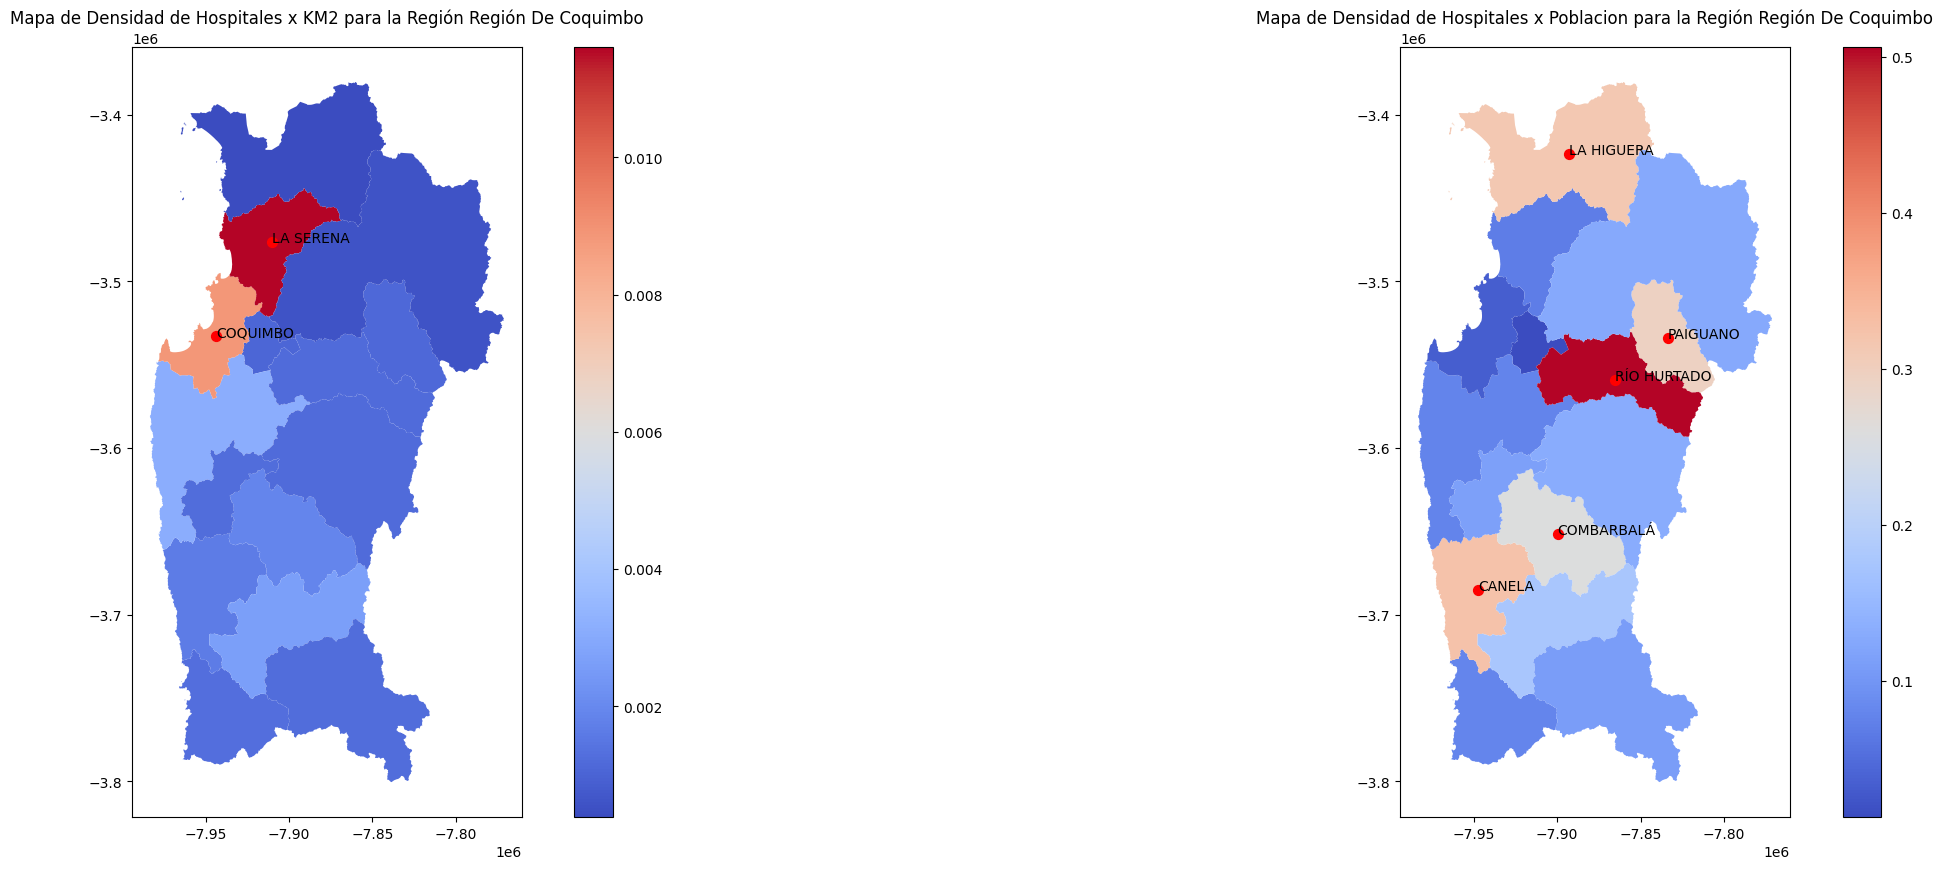

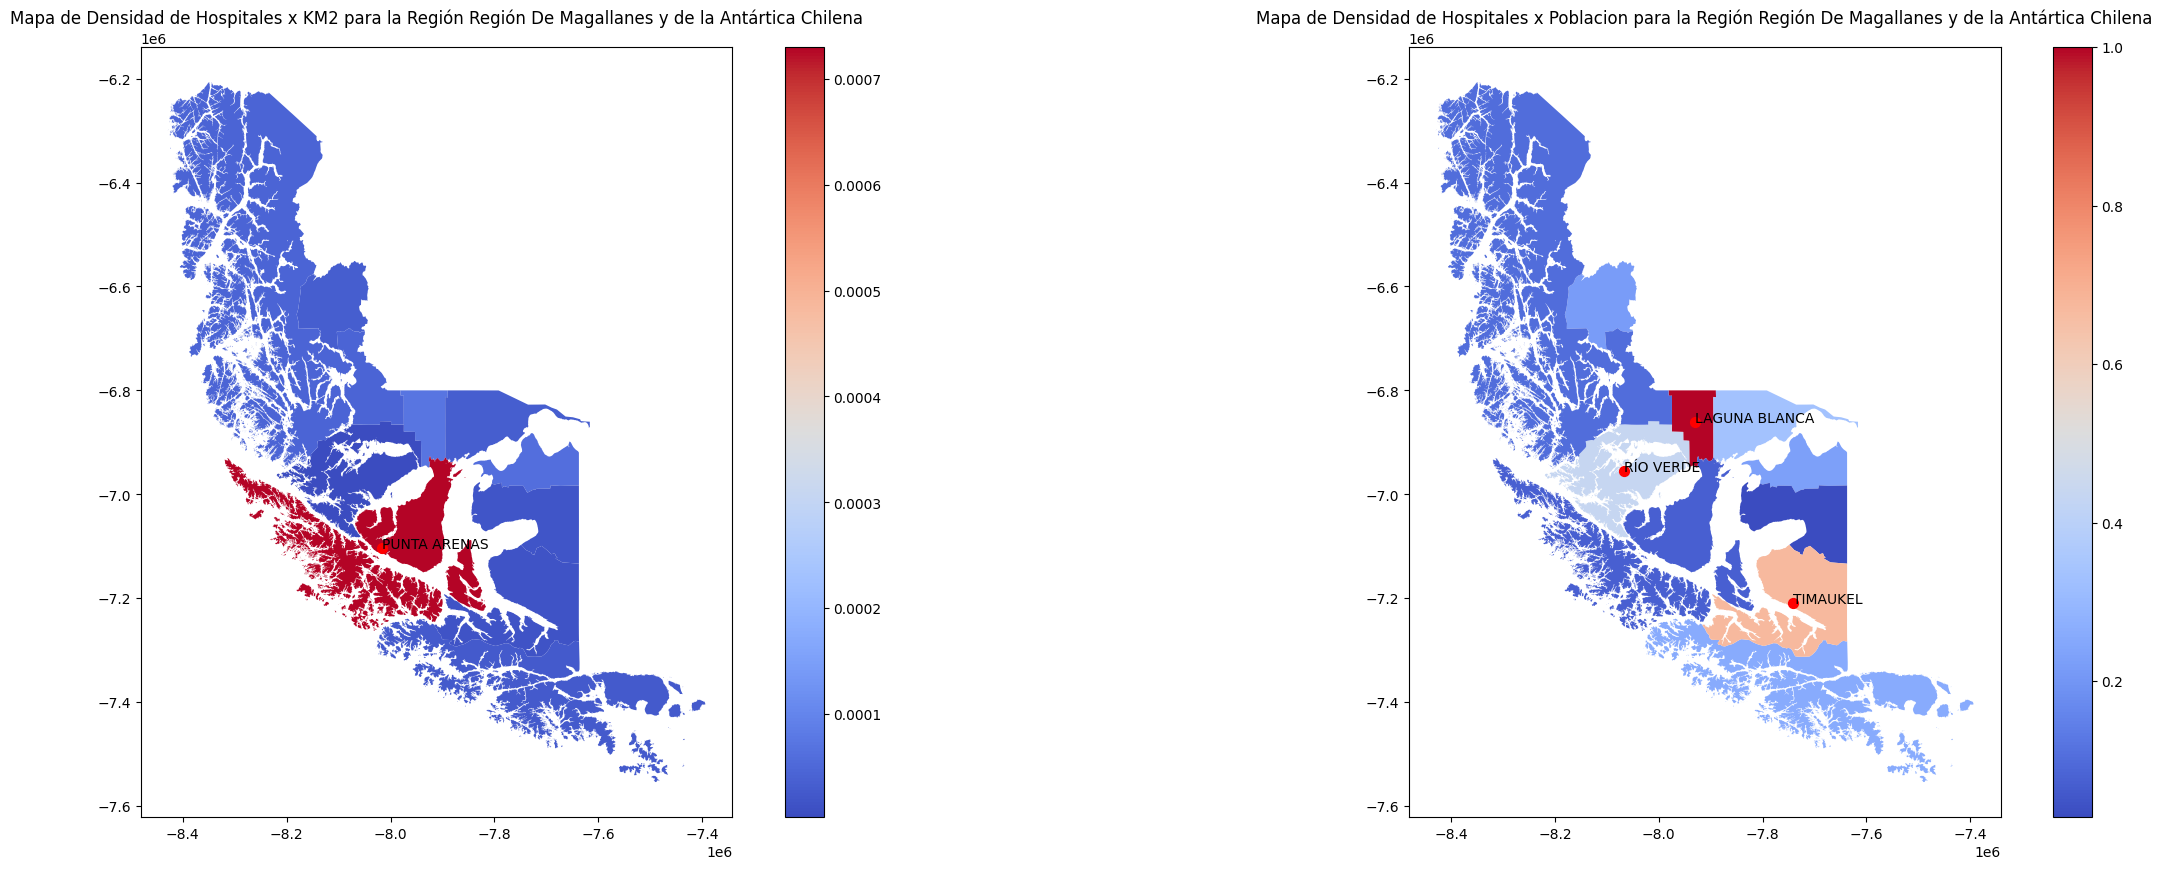

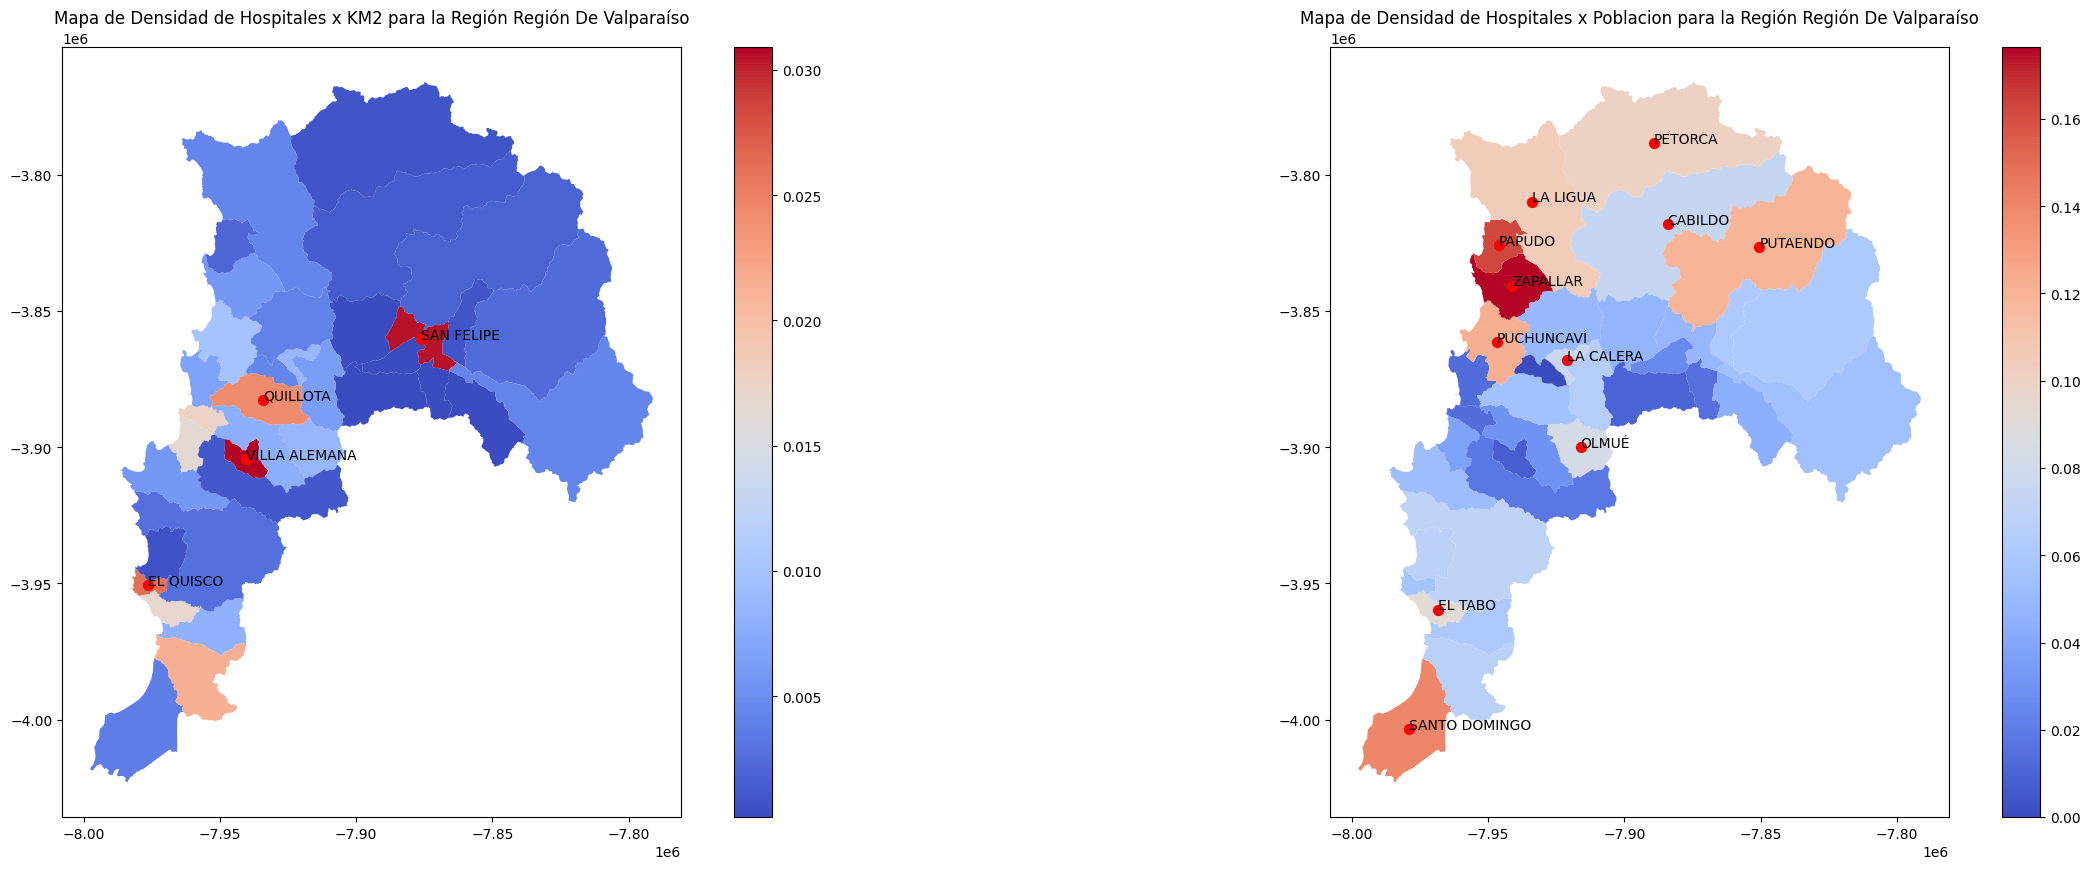

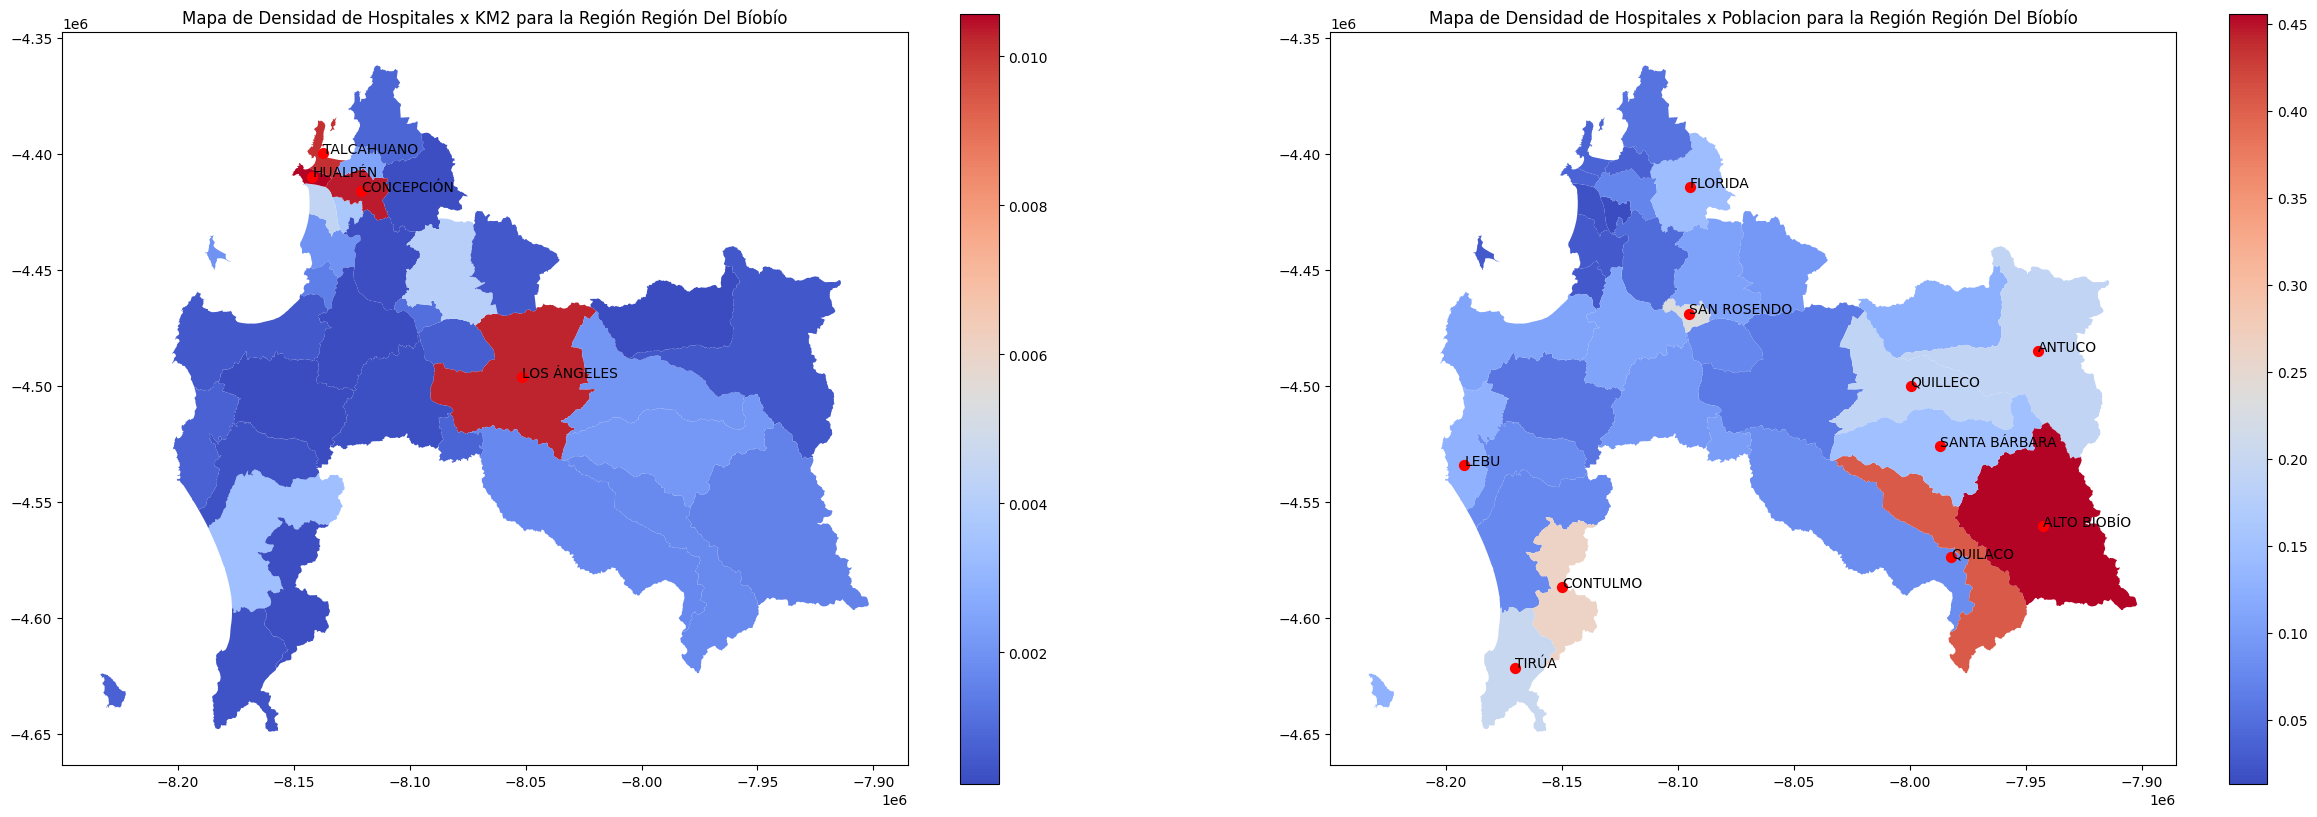

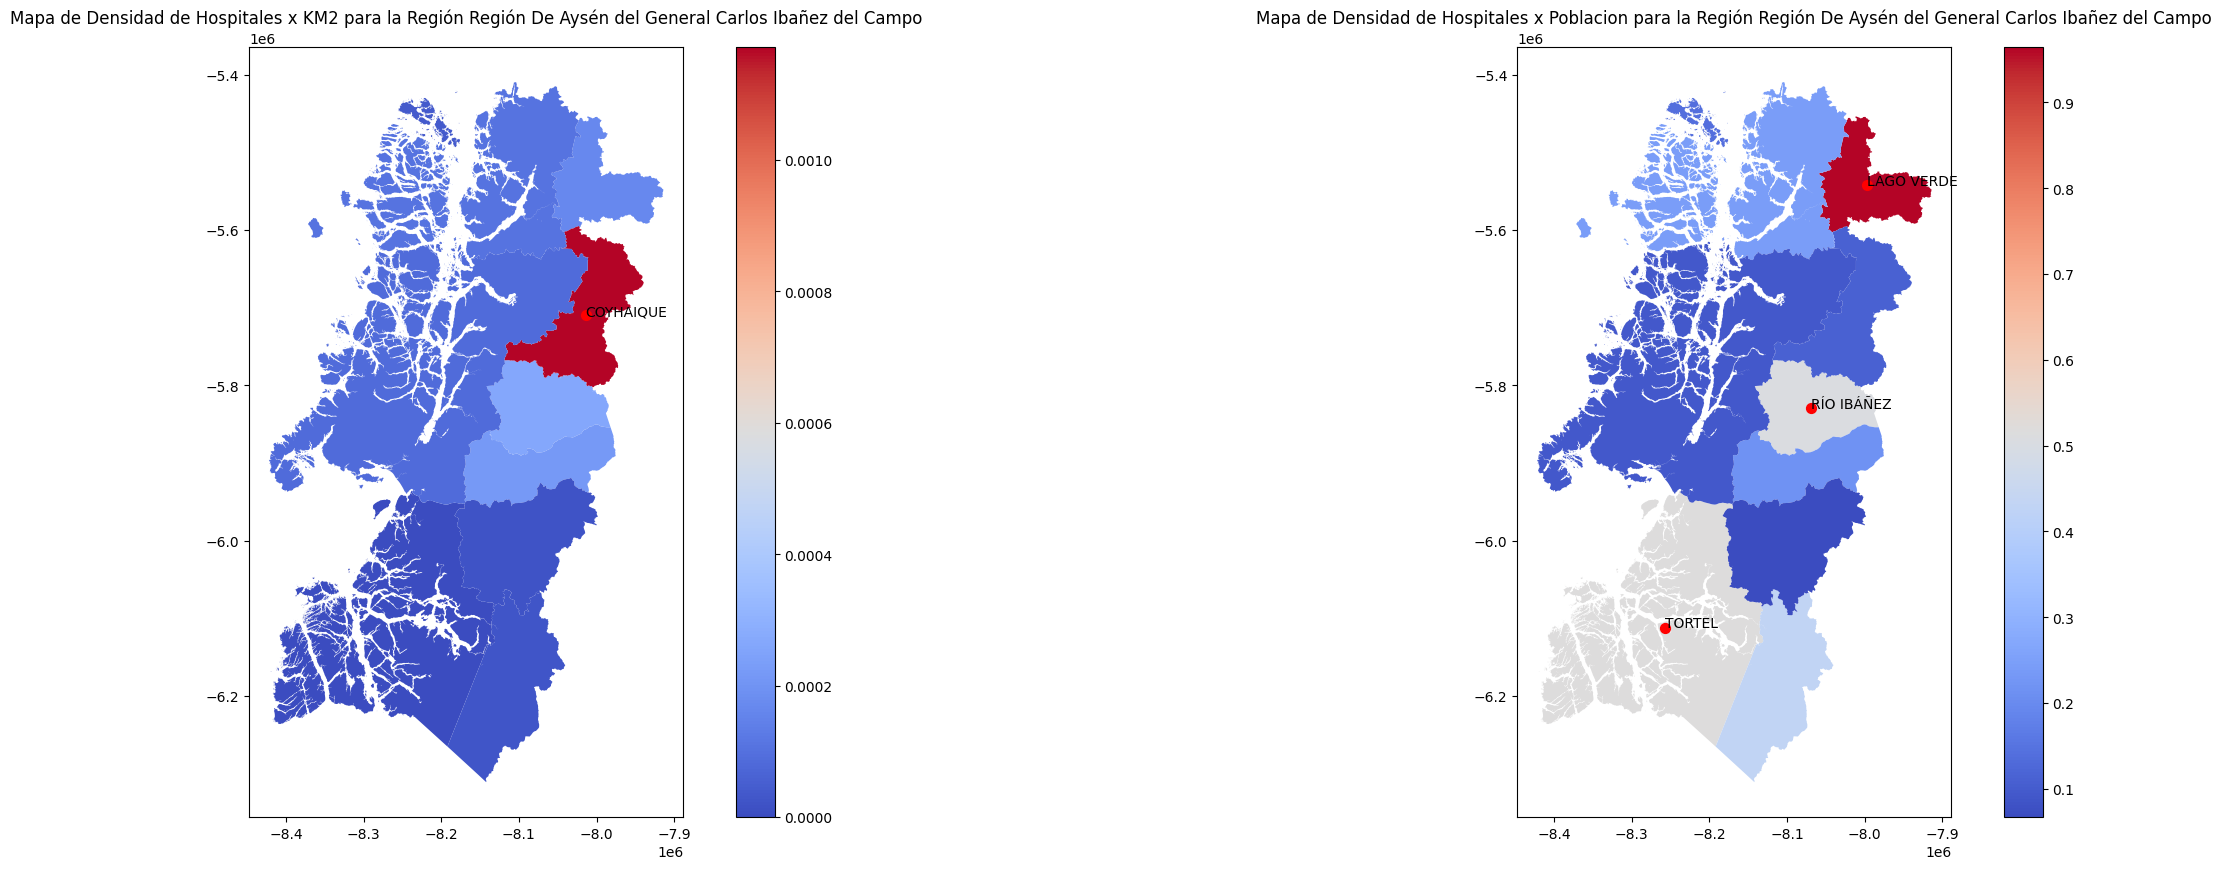

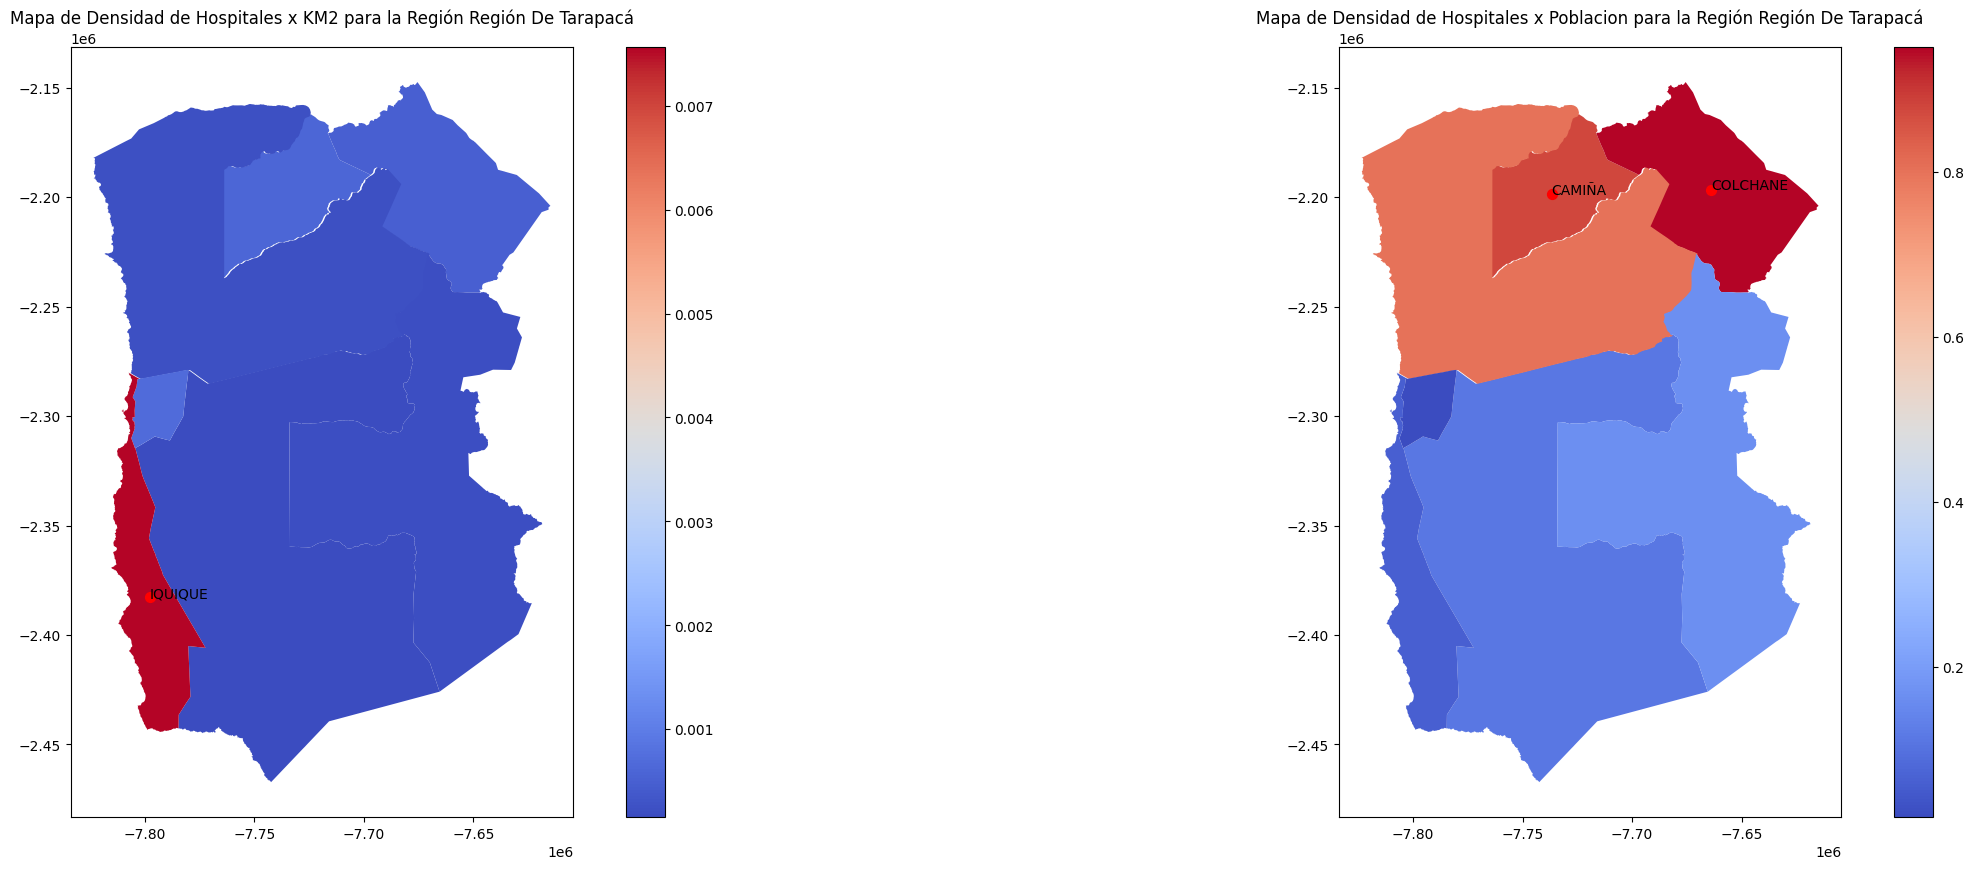

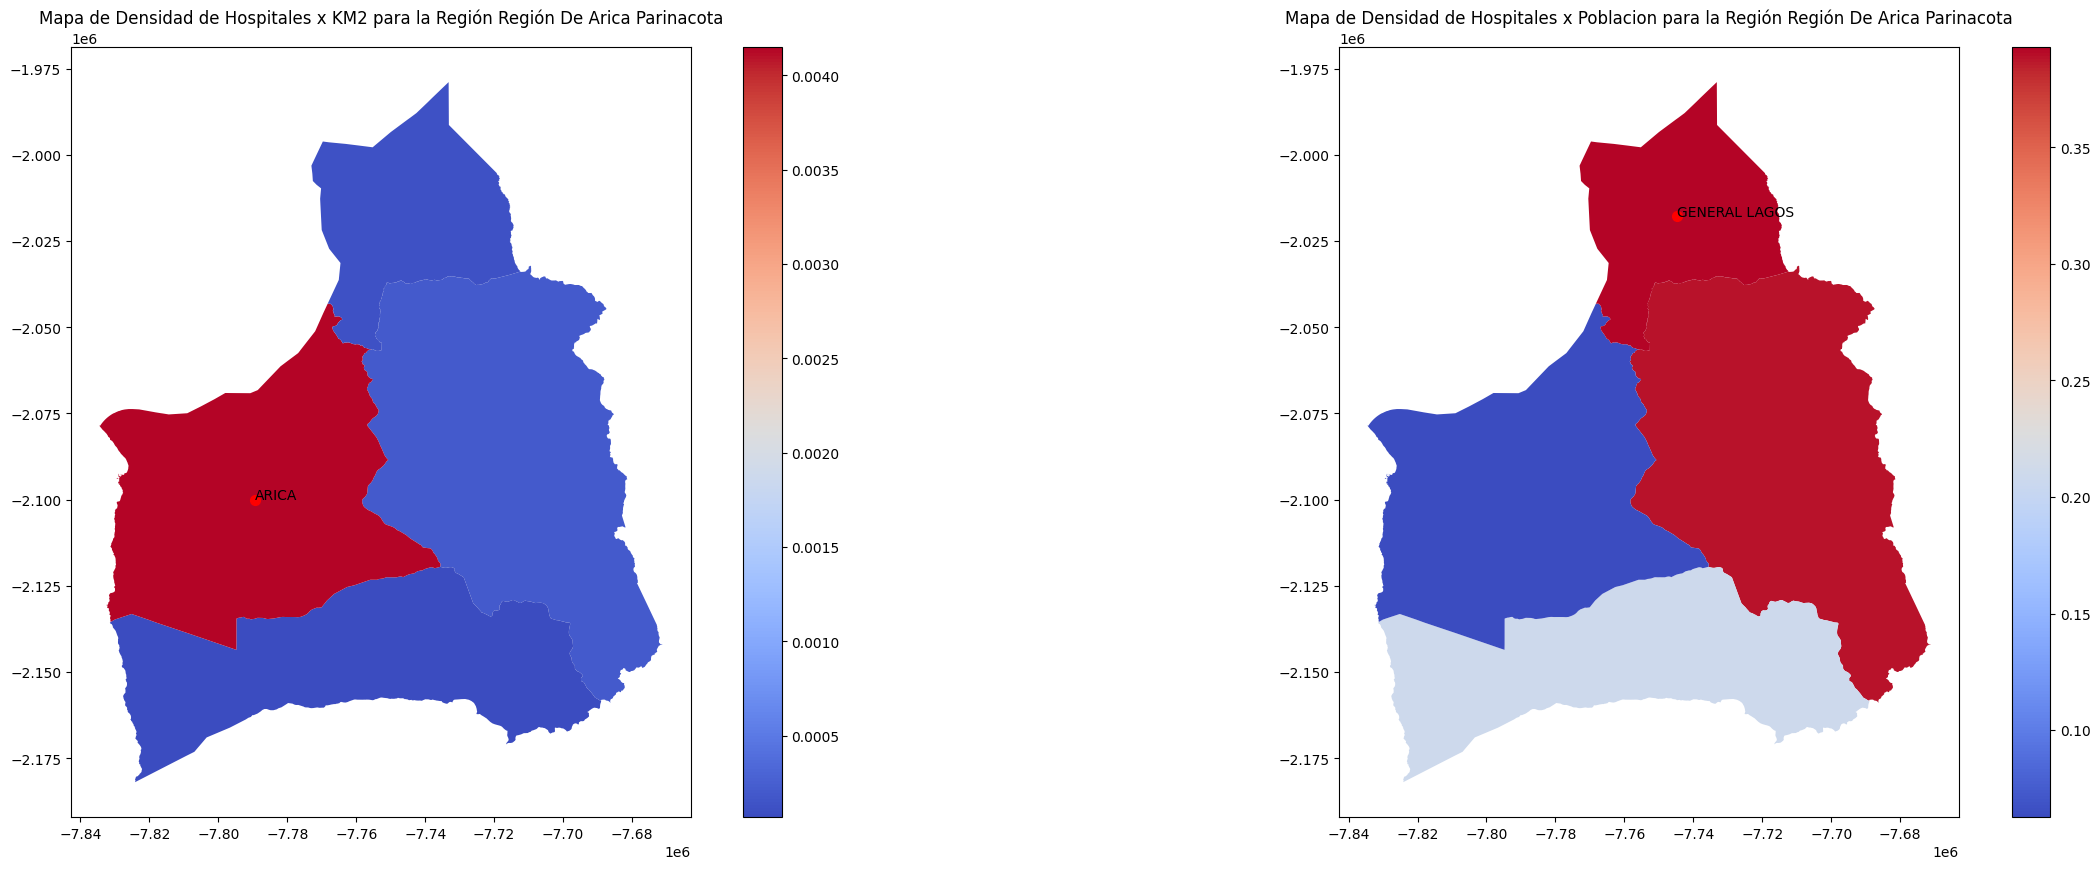

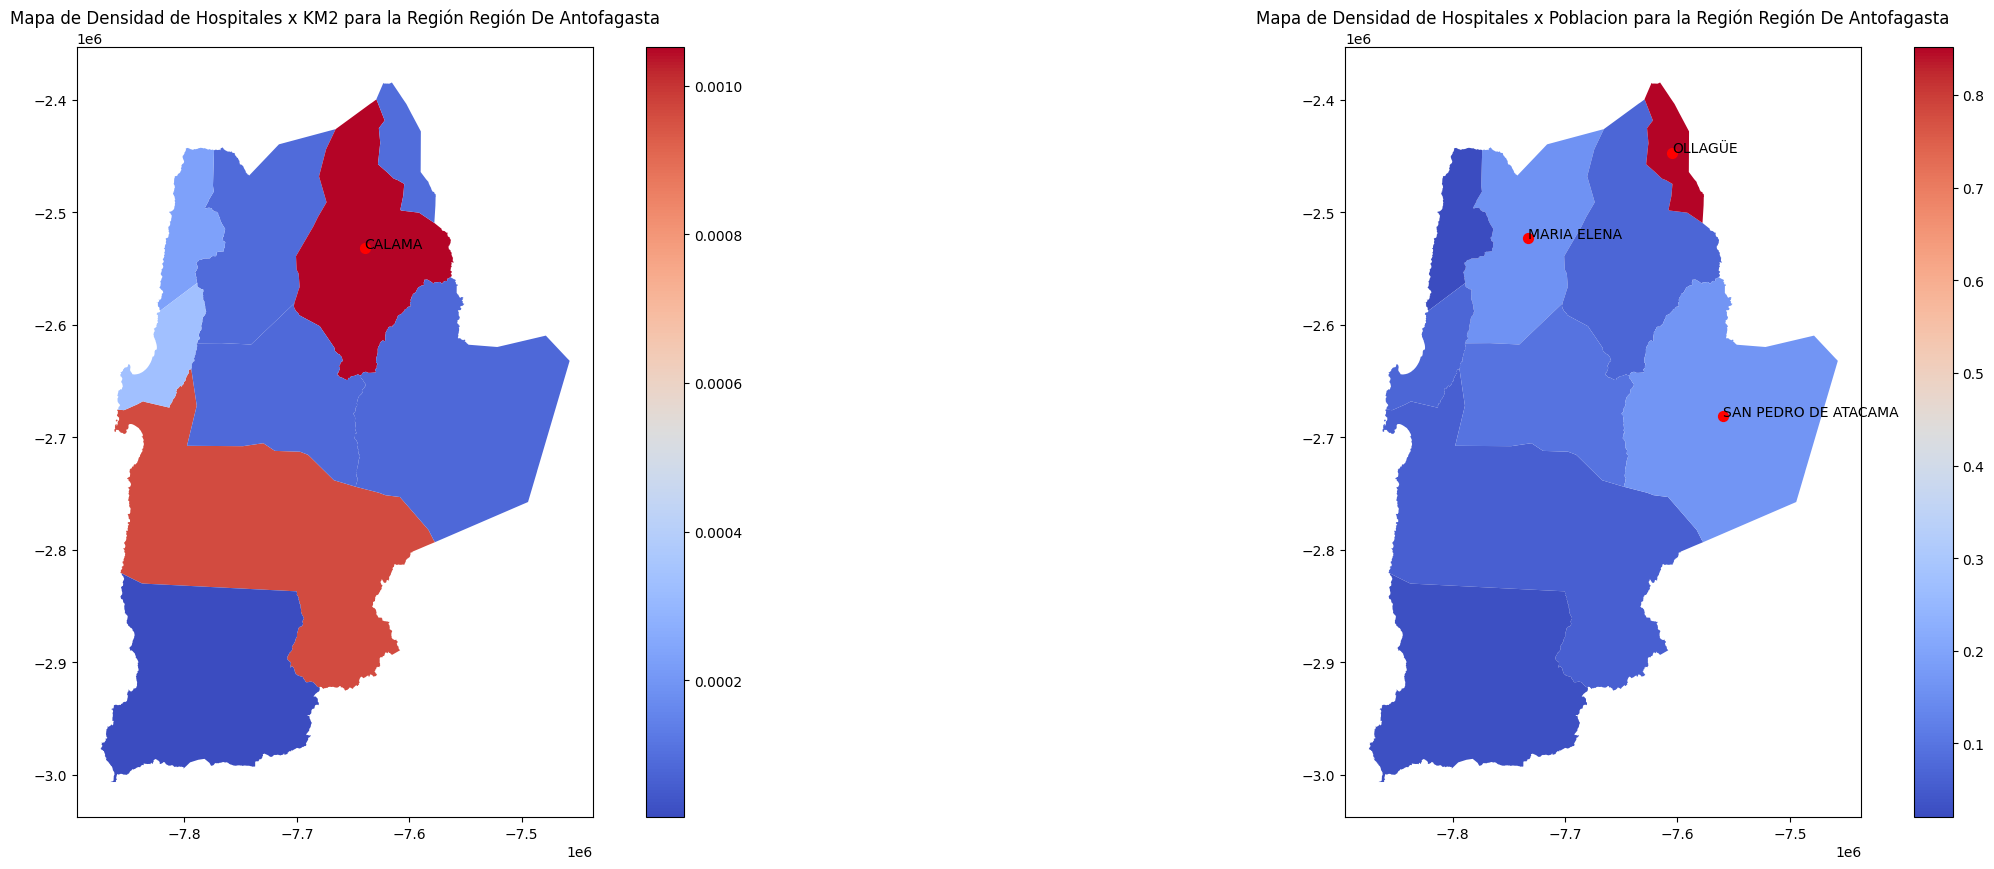

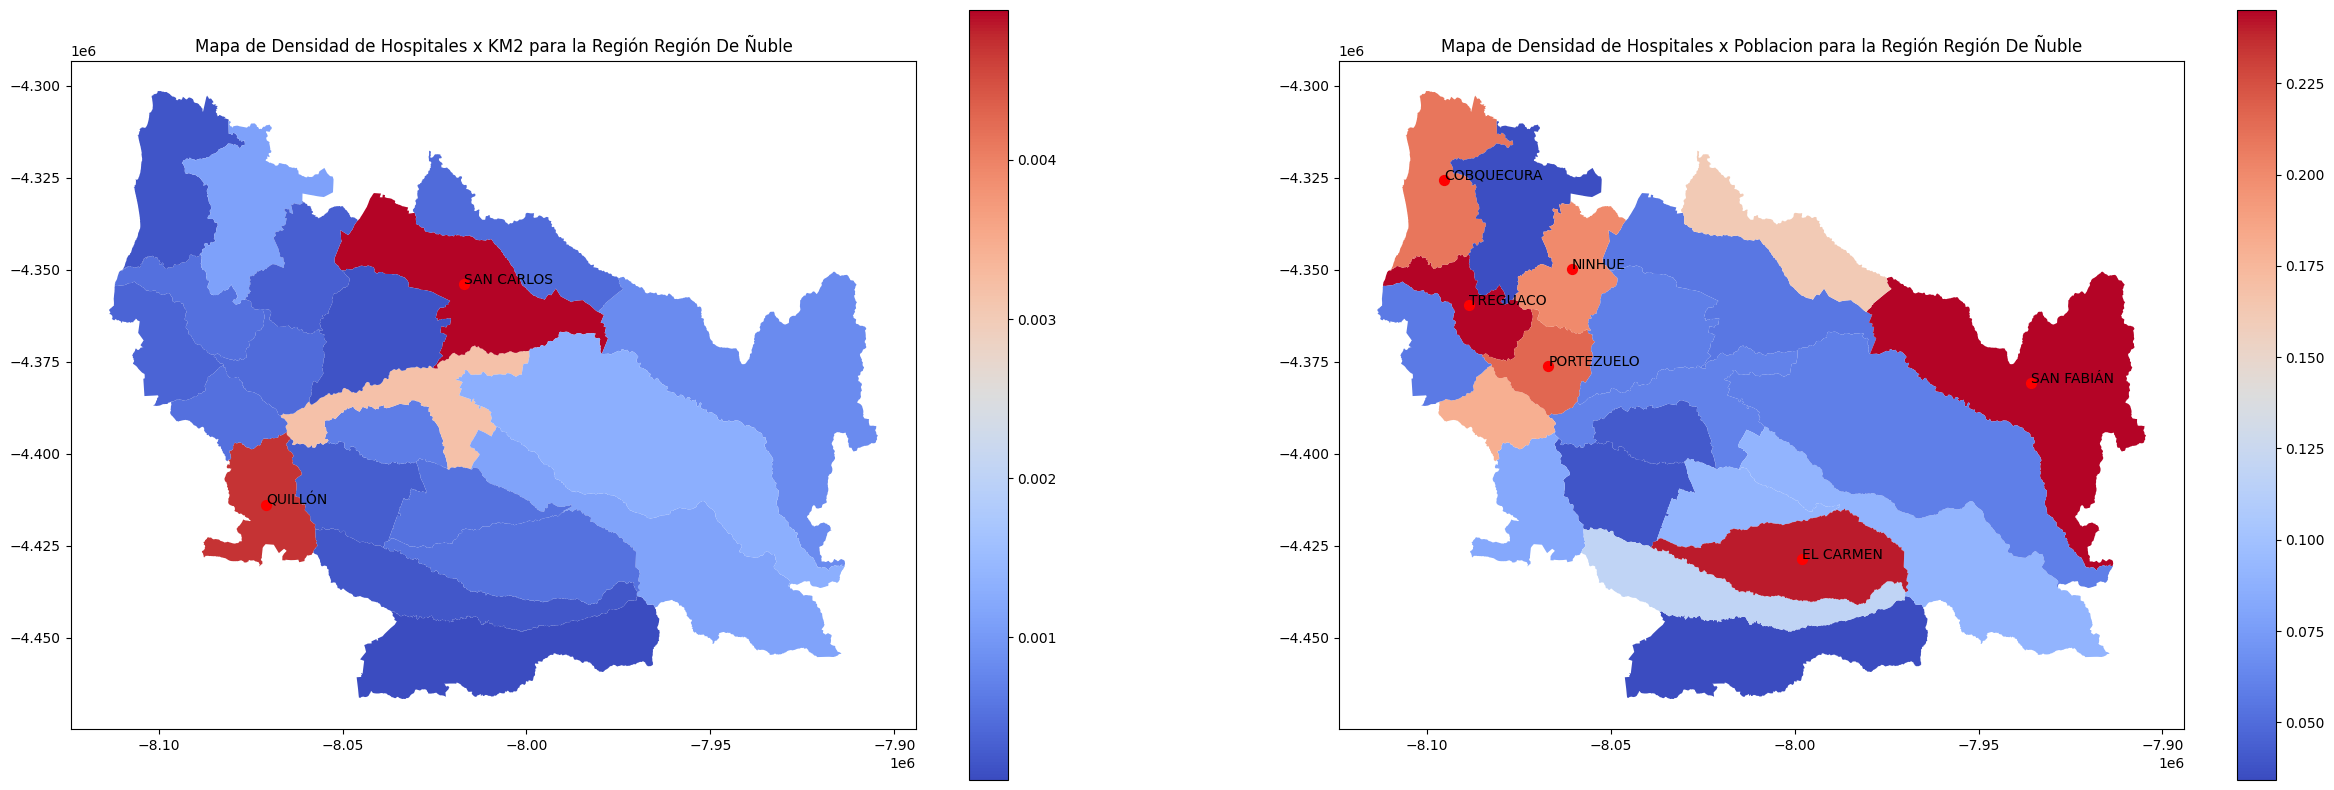

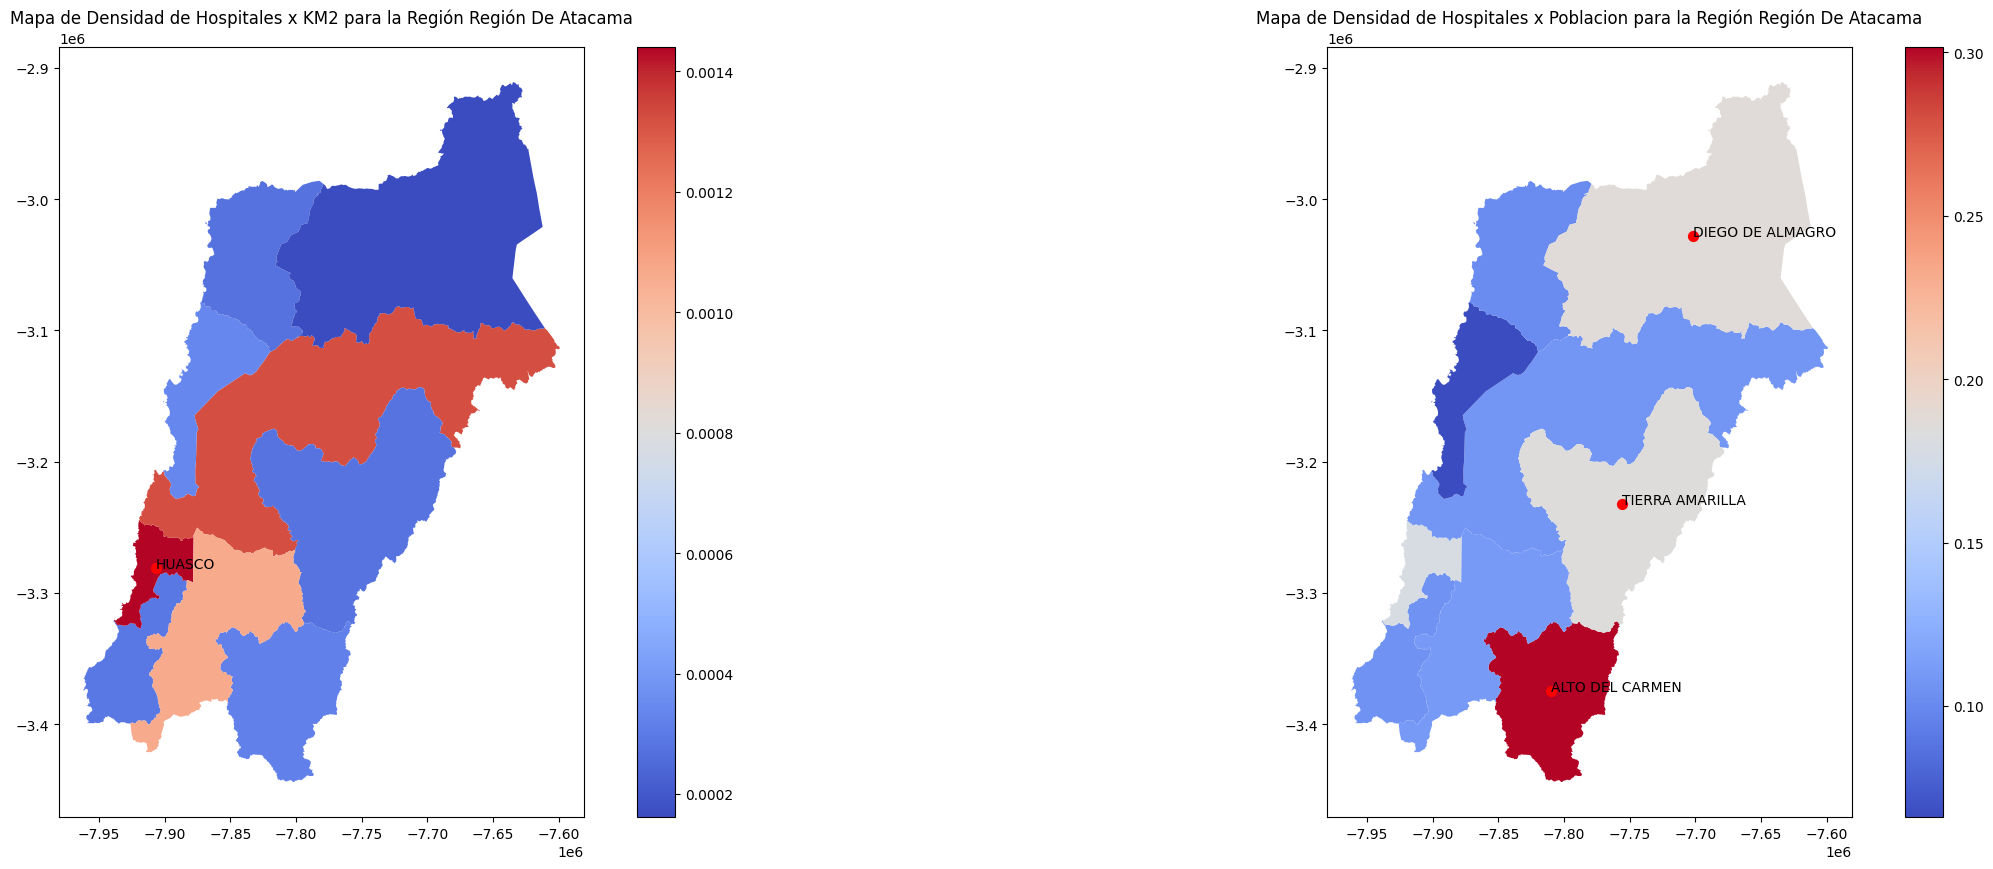

In [103]:
regiones = gdf["nombre_región"].unique()
var_densidad_poblacion = "densidad_hospital_x_km2_n"
var_densidad_hospitales = "densidad_hospital_x_poblacion_n"
for region in regiones:
    gdf_region = gdf[gdf["nombre_región"] == region]
    
    fig, axs = plt.subplots(1, 2, figsize=(30, 10))

    gdf_region.plot(column=var_densidad_poblacion, cmap='coolwarm', legend=True, ax=axs[0])
    
    q_densidad_poblacion = gdf_region[var_densidad_poblacion].quantile(0.9)
    gdf_region_filtrada_densidad = gdf_region[gdf_region[var_densidad_poblacion] > q_densidad_poblacion]

    for idx, row in gdf_region_filtrada_densidad.iterrows():
        axs[0].scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50) 
        axs[0].annotate(text=row["nombre_comuna"], xy=(row.geometry.centroid.x, row.geometry.centroid.y), color='black')

    axs[0].set_title(f'Mapa de Densidad de Hospitales x KM2 para la Región {region}')

    gdf_region.plot(column=var_densidad_hospitales, cmap='coolwarm', legend=True, ax=axs[1])
    
    q_densidad_hospitales = gdf_region[var_densidad_hospitales].quantile(0.7)
    gdf_region_filtrada_hospitales = gdf_region[gdf_region[var_densidad_hospitales] > q_densidad_hospitales]

    for idx, row in gdf_region_filtrada_hospitales.iterrows():
        axs[1].scatter(row.geometry.centroid.x, row.geometry.centroid.y, color='red', s=50) 
        axs[1].annotate(text=row["nombre_comuna"], xy=(row.geometry.centroid.x, row.geometry.centroid.y), color='black')

    axs[1].set_title(f'Mapa de Densidad de Hospitales x Poblacion para la Región {region}')

    plt.show()

### Pregunta 02: ¿Hay alguna comuna y/o regi ́on que no tenga un establecimientos de todos los tipos de complejidad y tipo de emergencia?